# Imports & notebook setup

In [1]:
# import os
# print(os.environ.get('CUDA_LAUNCH_BLOCKING', None))
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# print(os.environ.get('CUDA_LAUNCH_BLOCKING', None))

In [2]:
# Generic
from pathlib import Path
import typing
import itertools

# Numerical Computing
import numpy as np
import torch
import pandas as pd
from jaxtyping import Bool, Int, Float
from muutils.nbutils.configure_notebook import configure_notebook

# Our Code
# dataset stuff
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS, LatticeMazeGenerators, CoordArray
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode

# model stuff
from maze_transformer.training.config import ZanjHookedTransformer

# mechinterp stuff
from maze_transformer.mechinterp.logit_attrib_task import LOGIT_ATTRIB_TASKS
from maze_transformer.evaluation.load_model_testdata import load_model_with_test_data
from maze_transformer.evaluation.eval_single_token_tasks import TaskPrompt, TaskEvalResult, get_task_prompts_targets, eval_model_across_tasks
from maze_transformer.mechinterp.logit_attrib_task import LOGIT_ATTRIB_TASKS
from maze_transformer.evaluation.eval_model import predict_maze_paths
from maze_transformer.evaluation.path_evals import rollout_evals



In [3]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)

set up plots with PLOT_MODE = 'inline', FIG_OUTPUT_FMT = None, FIG_BASEPATH = None
DEVICE = device(type='cuda')


# Configuration

which models to evaluate, how many mazes to use for evaluation, and which datasets to use

In [4]:
MODELS_PATHS: list[str] = [
	"../models/model.hallway-jvq.final.zanj",
	"../models/wandb.jerpkipj.zanj",
]

N_MAZES: int = 128
GRID_N_VALS: list[int] = [6, 7]
SEED=46

DATASET_CFG_SOURCES: list[MazeDatasetConfig] = list(itertools.chain.from_iterable([
	[
		MazeDatasetConfig(
			name="forkless",
			grid_n=grid_n,
			n_mazes=N_MAZES,
			maze_ctor=LatticeMazeGenerators.gen_dfs,
			maze_ctor_kwargs=dict(do_forks=False),
			applied_filters=[{'name': 'path_length', 'args': (), 'kwargs': {"min_length": 6}}],
			seed=SEED,
		),
		MazeDatasetConfig(
			name="RDFS",
			grid_n=grid_n,
			n_mazes=N_MAZES,
			maze_ctor=LatticeMazeGenerators.gen_dfs,
			maze_ctor_kwargs=dict(do_forks=True),
			applied_filters=[{'name': 'path_length', 'args': (), 'kwargs': {"min_length": 6}}],
			seed=SEED,
		),
		MazeDatasetConfig(
			name="pRDFS",
			grid_n=grid_n,
			n_mazes=N_MAZES,
			maze_ctor=LatticeMazeGenerators.gen_dfs_percolation,
			maze_ctor_kwargs=dict(p=0.1),
			applied_filters=[{'name': 'path_length', 'args': (), 'kwargs': {"min_length": 6}}],
			seed=SEED,
		),
	]
	for grid_n in GRID_N_VALS
]))

F:\KNC\maze-dataset\maze_dataset\dataset\dataset.py:61: UserWarning:

in GPTDatasetConfig self.name='forkless', self.seed=46 is trying to override GLOBAL_SEED=42 which has already been changed elsewhere from DEFAULT_SEED=42

F:\KNC\maze-dataset\maze_dataset\dataset\dataset.py:61: UserWarning:

in GPTDatasetConfig self.name='RDFS', self.seed=46 is trying to override GLOBAL_SEED=42 which has already been changed elsewhere from DEFAULT_SEED=42

F:\KNC\maze-dataset\maze_dataset\dataset\dataset.py:61: UserWarning:

in GPTDatasetConfig self.name='pRDFS', self.seed=46 is trying to override GLOBAL_SEED=42 which has already been changed elsewhere from DEFAULT_SEED=42



# create and inspect datasets

In [5]:
DATASETS: list[MazeDataset] = [
	MazeDataset.from_config(dcs)
	for dcs in DATASET_CFG_SOURCES
]

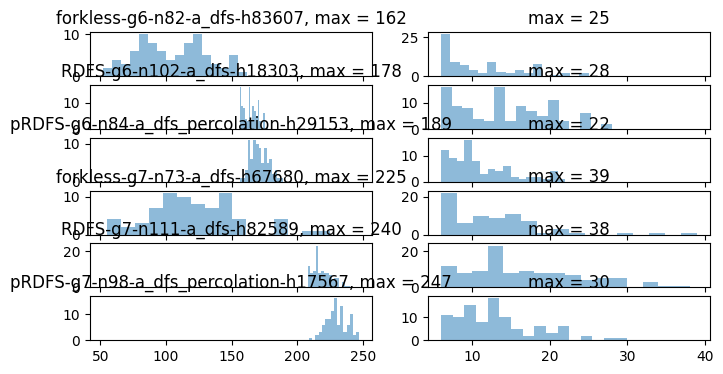

In [6]:
# print the distribution of path lengths for each dataset
import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(DATASETS), 2, figsize=(8, 4), sharex="col")
placeholder_tokenizer: MazeTokenizer = MazeTokenizer(tokenization_mode=TokenizationMode.AOTP_UT_uniform, max_grid_size=16)
for i, ds in enumerate(DATASETS):
	total_lengths = [len(maze.as_tokens(placeholder_tokenizer)) for maze in ds]
	path_lengths = [len(maze.solution) for maze in ds]
	ax[i, 0].hist(total_lengths, bins=16, alpha=0.5, label="total lengths")
	ax[i, 1].hist(path_lengths, bins=16, alpha=0.5, label="path lengths")
	ax[i, 0].set_title(f"{ds.cfg.to_fname()}, max = {max(total_lengths)}")
	ax[i, 1].set_title(f"max = {max(path_lengths)}")

--------------------------------------------------
loaded model with 1.2M params (num_params = 1238076) from:
	path: ../models/model.hallway-jvq.final.zanj
	original model name: 'model.zanj_model_config.name = 'hallway_v3'', changing to 'hallway-jvq.final'
	model tensors on devices: {device(type='cuda', index=0)}
rollouts for ../models/model.hallway-jvq.final.zanj on forkless-g6-n82-a_dfs-h83607


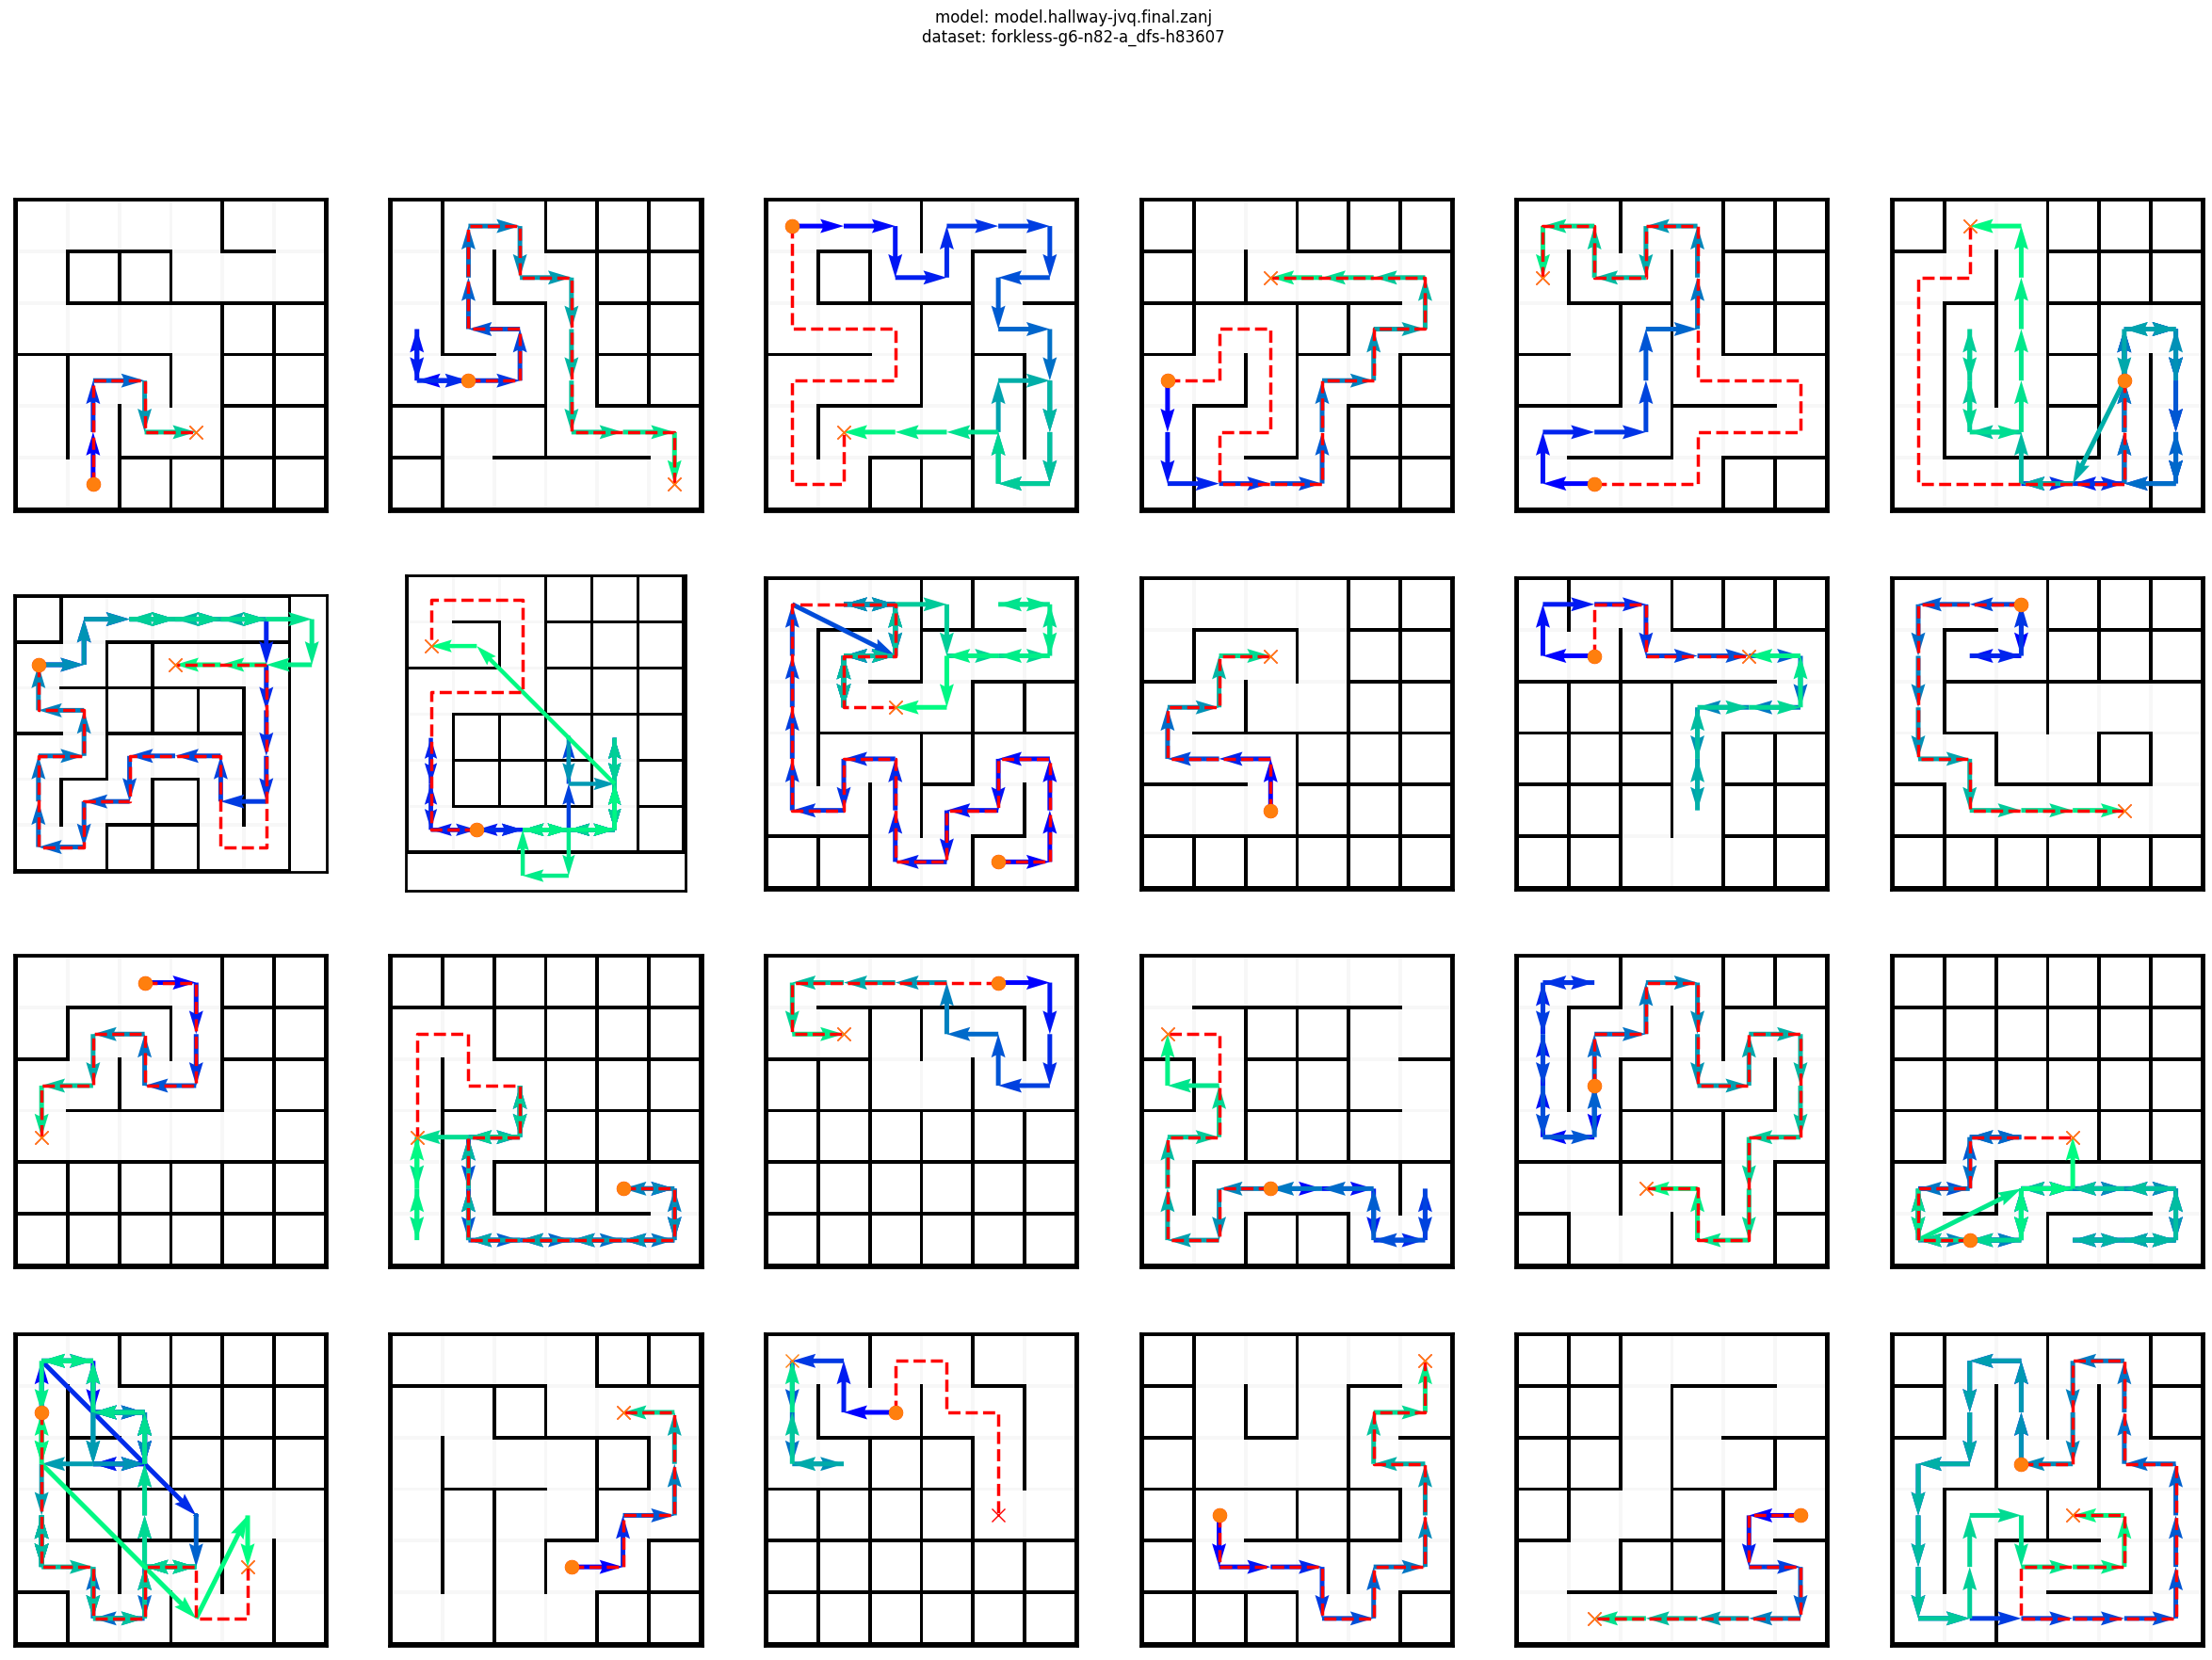

rollouts for ../models/model.hallway-jvq.final.zanj on RDFS-g6-n102-a_dfs-h18303


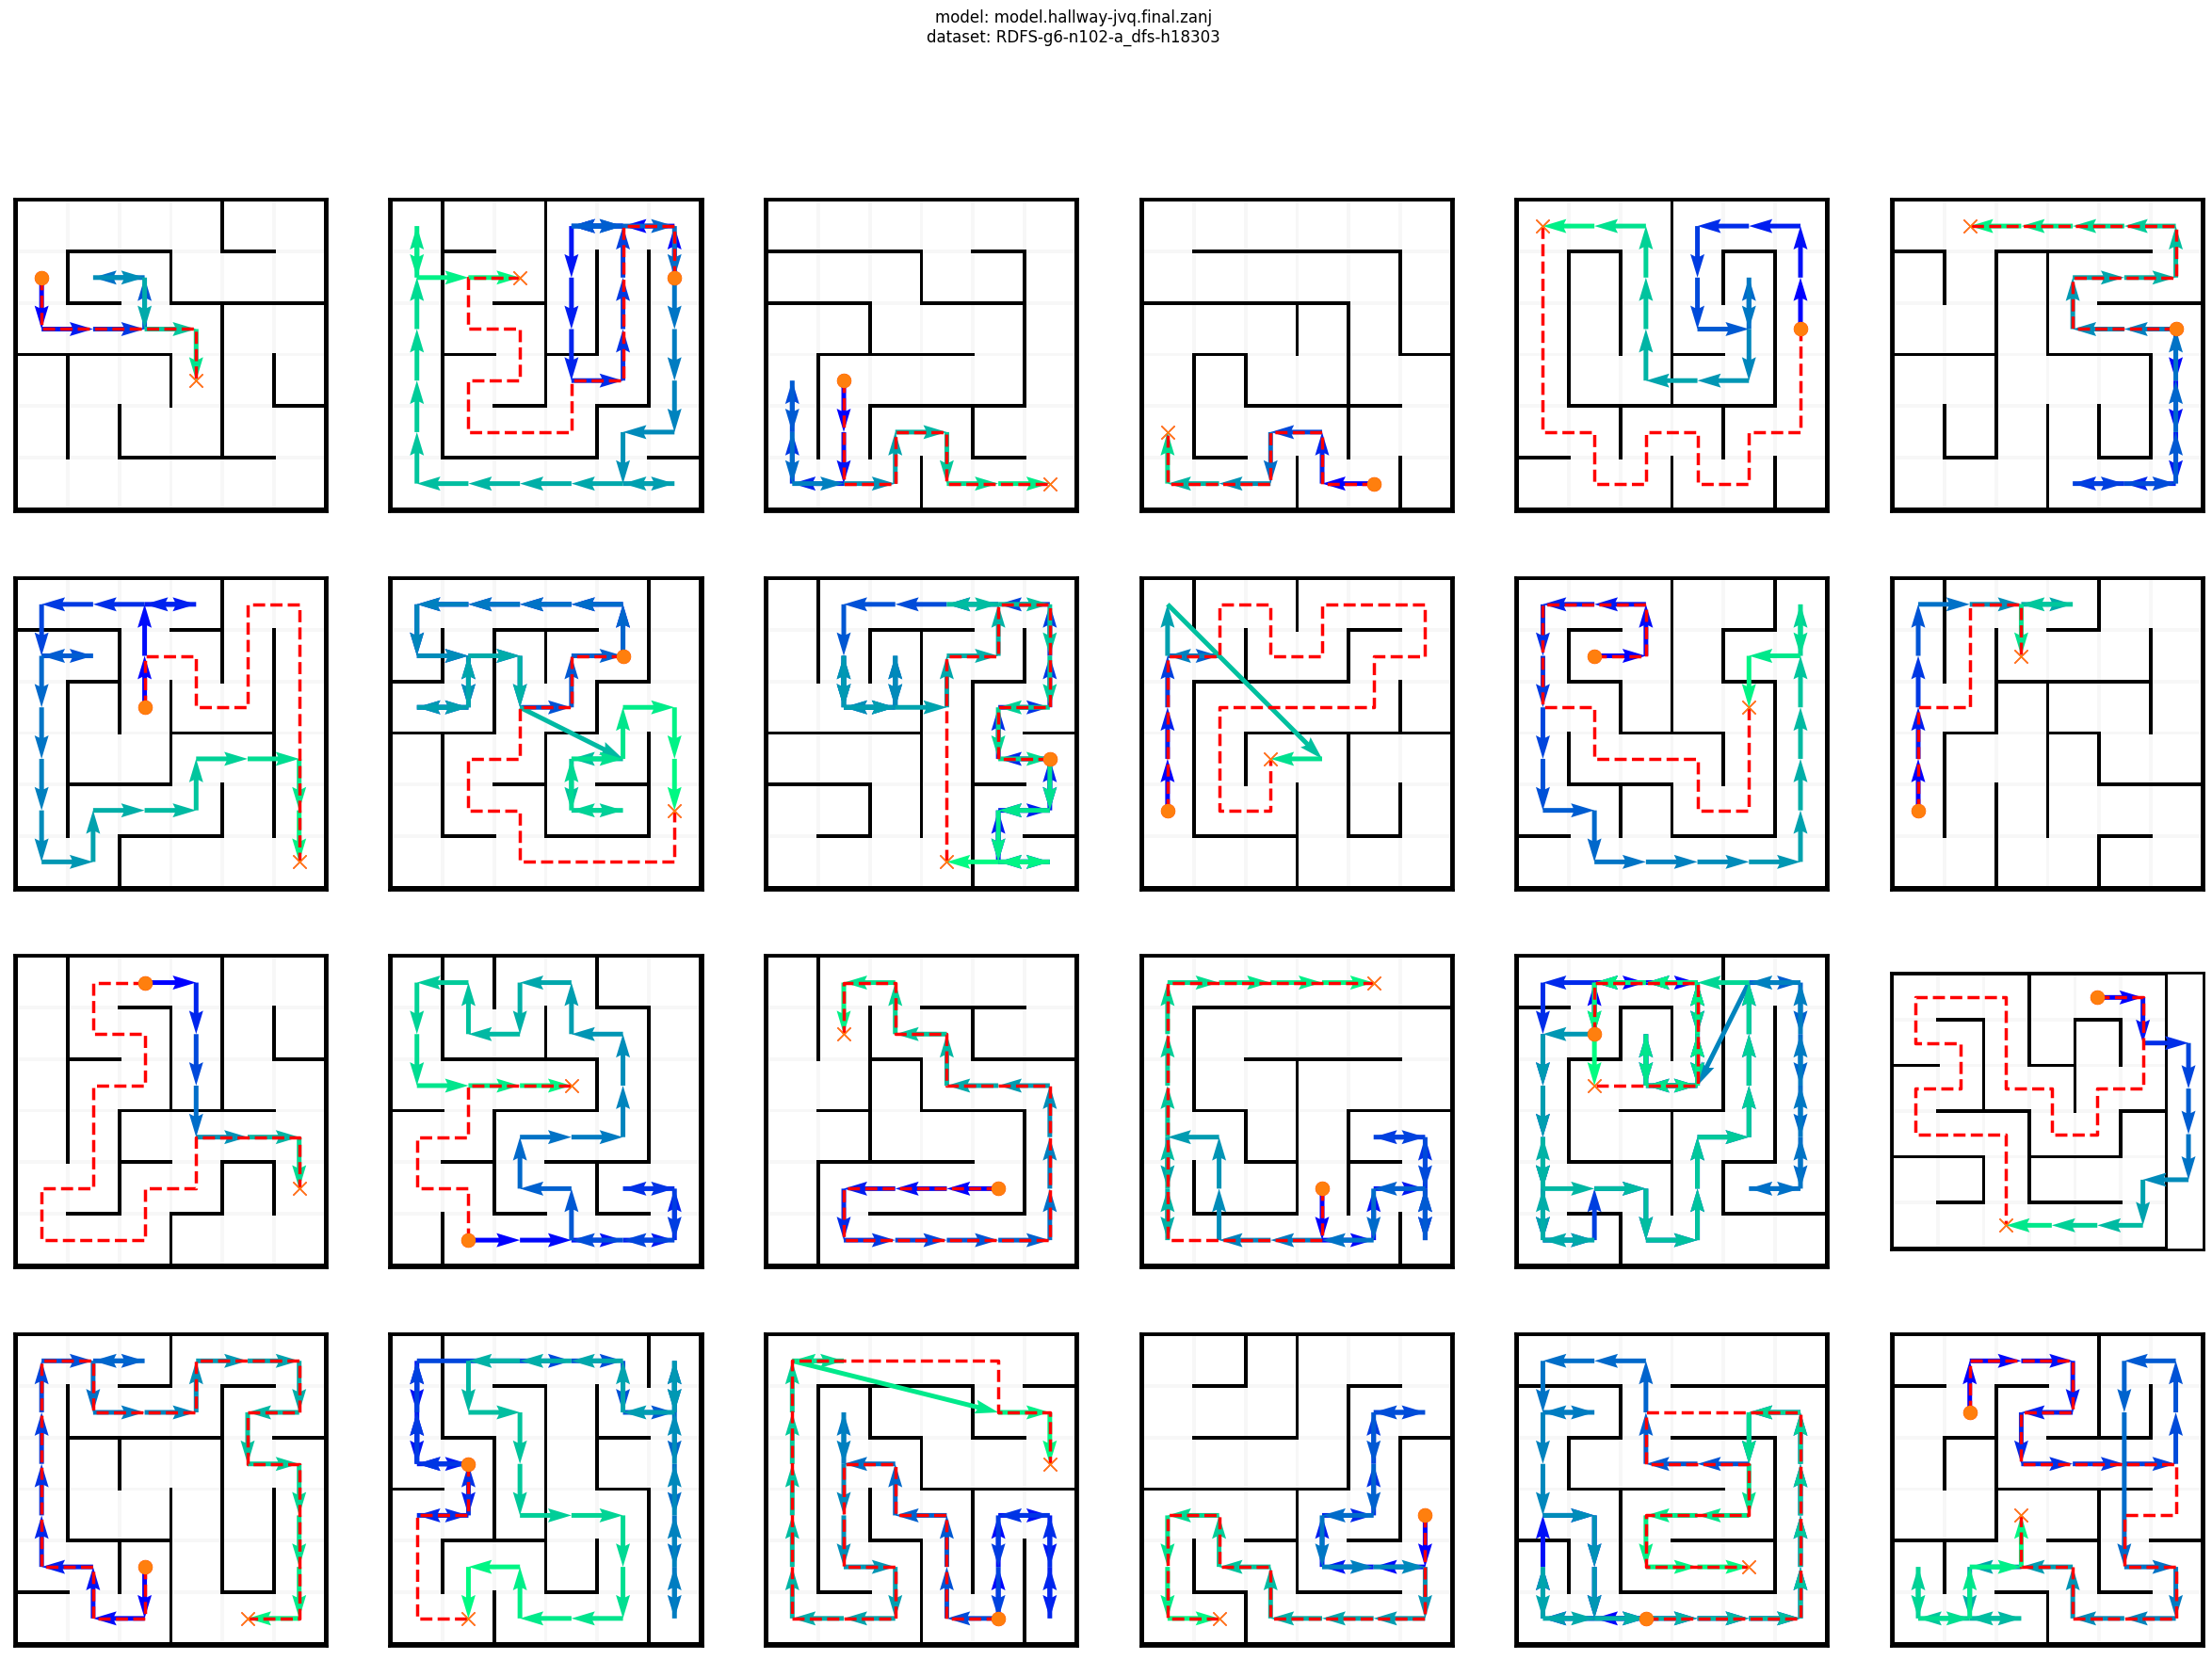

rollouts for ../models/model.hallway-jvq.final.zanj on pRDFS-g6-n84-a_dfs_percolation-h29153


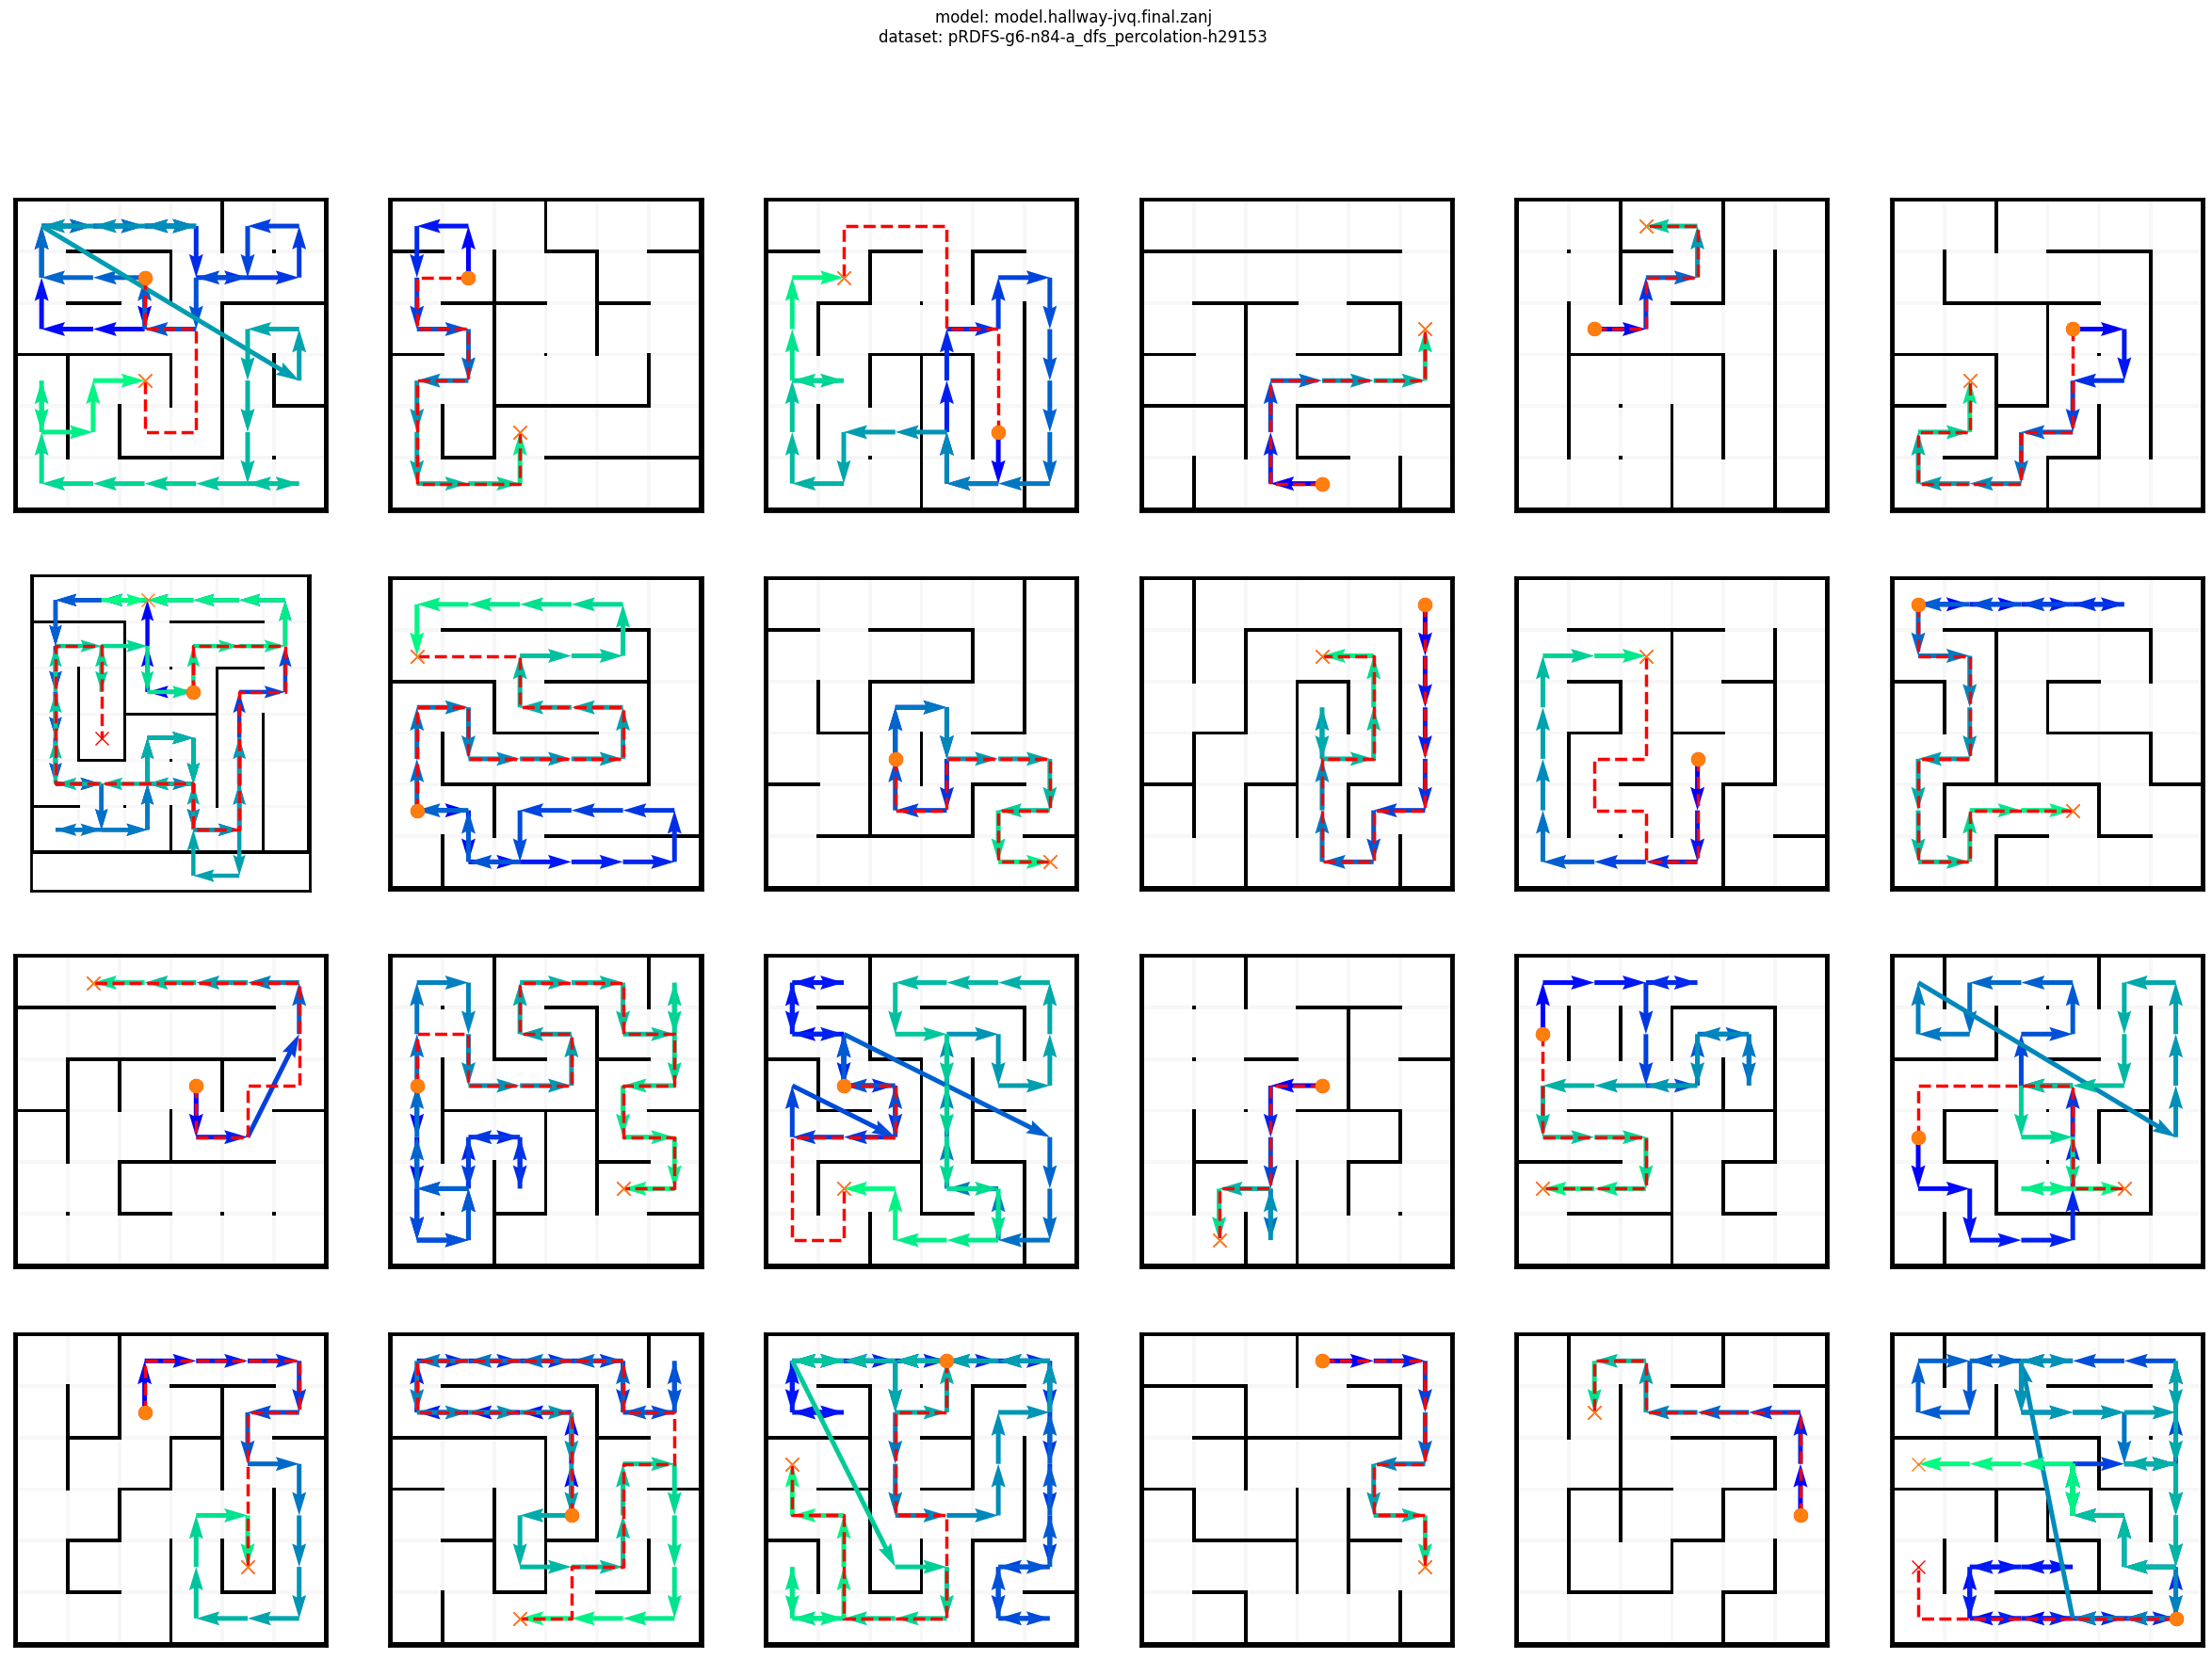

rollouts for ../models/model.hallway-jvq.final.zanj on forkless-g7-n73-a_dfs-h67680


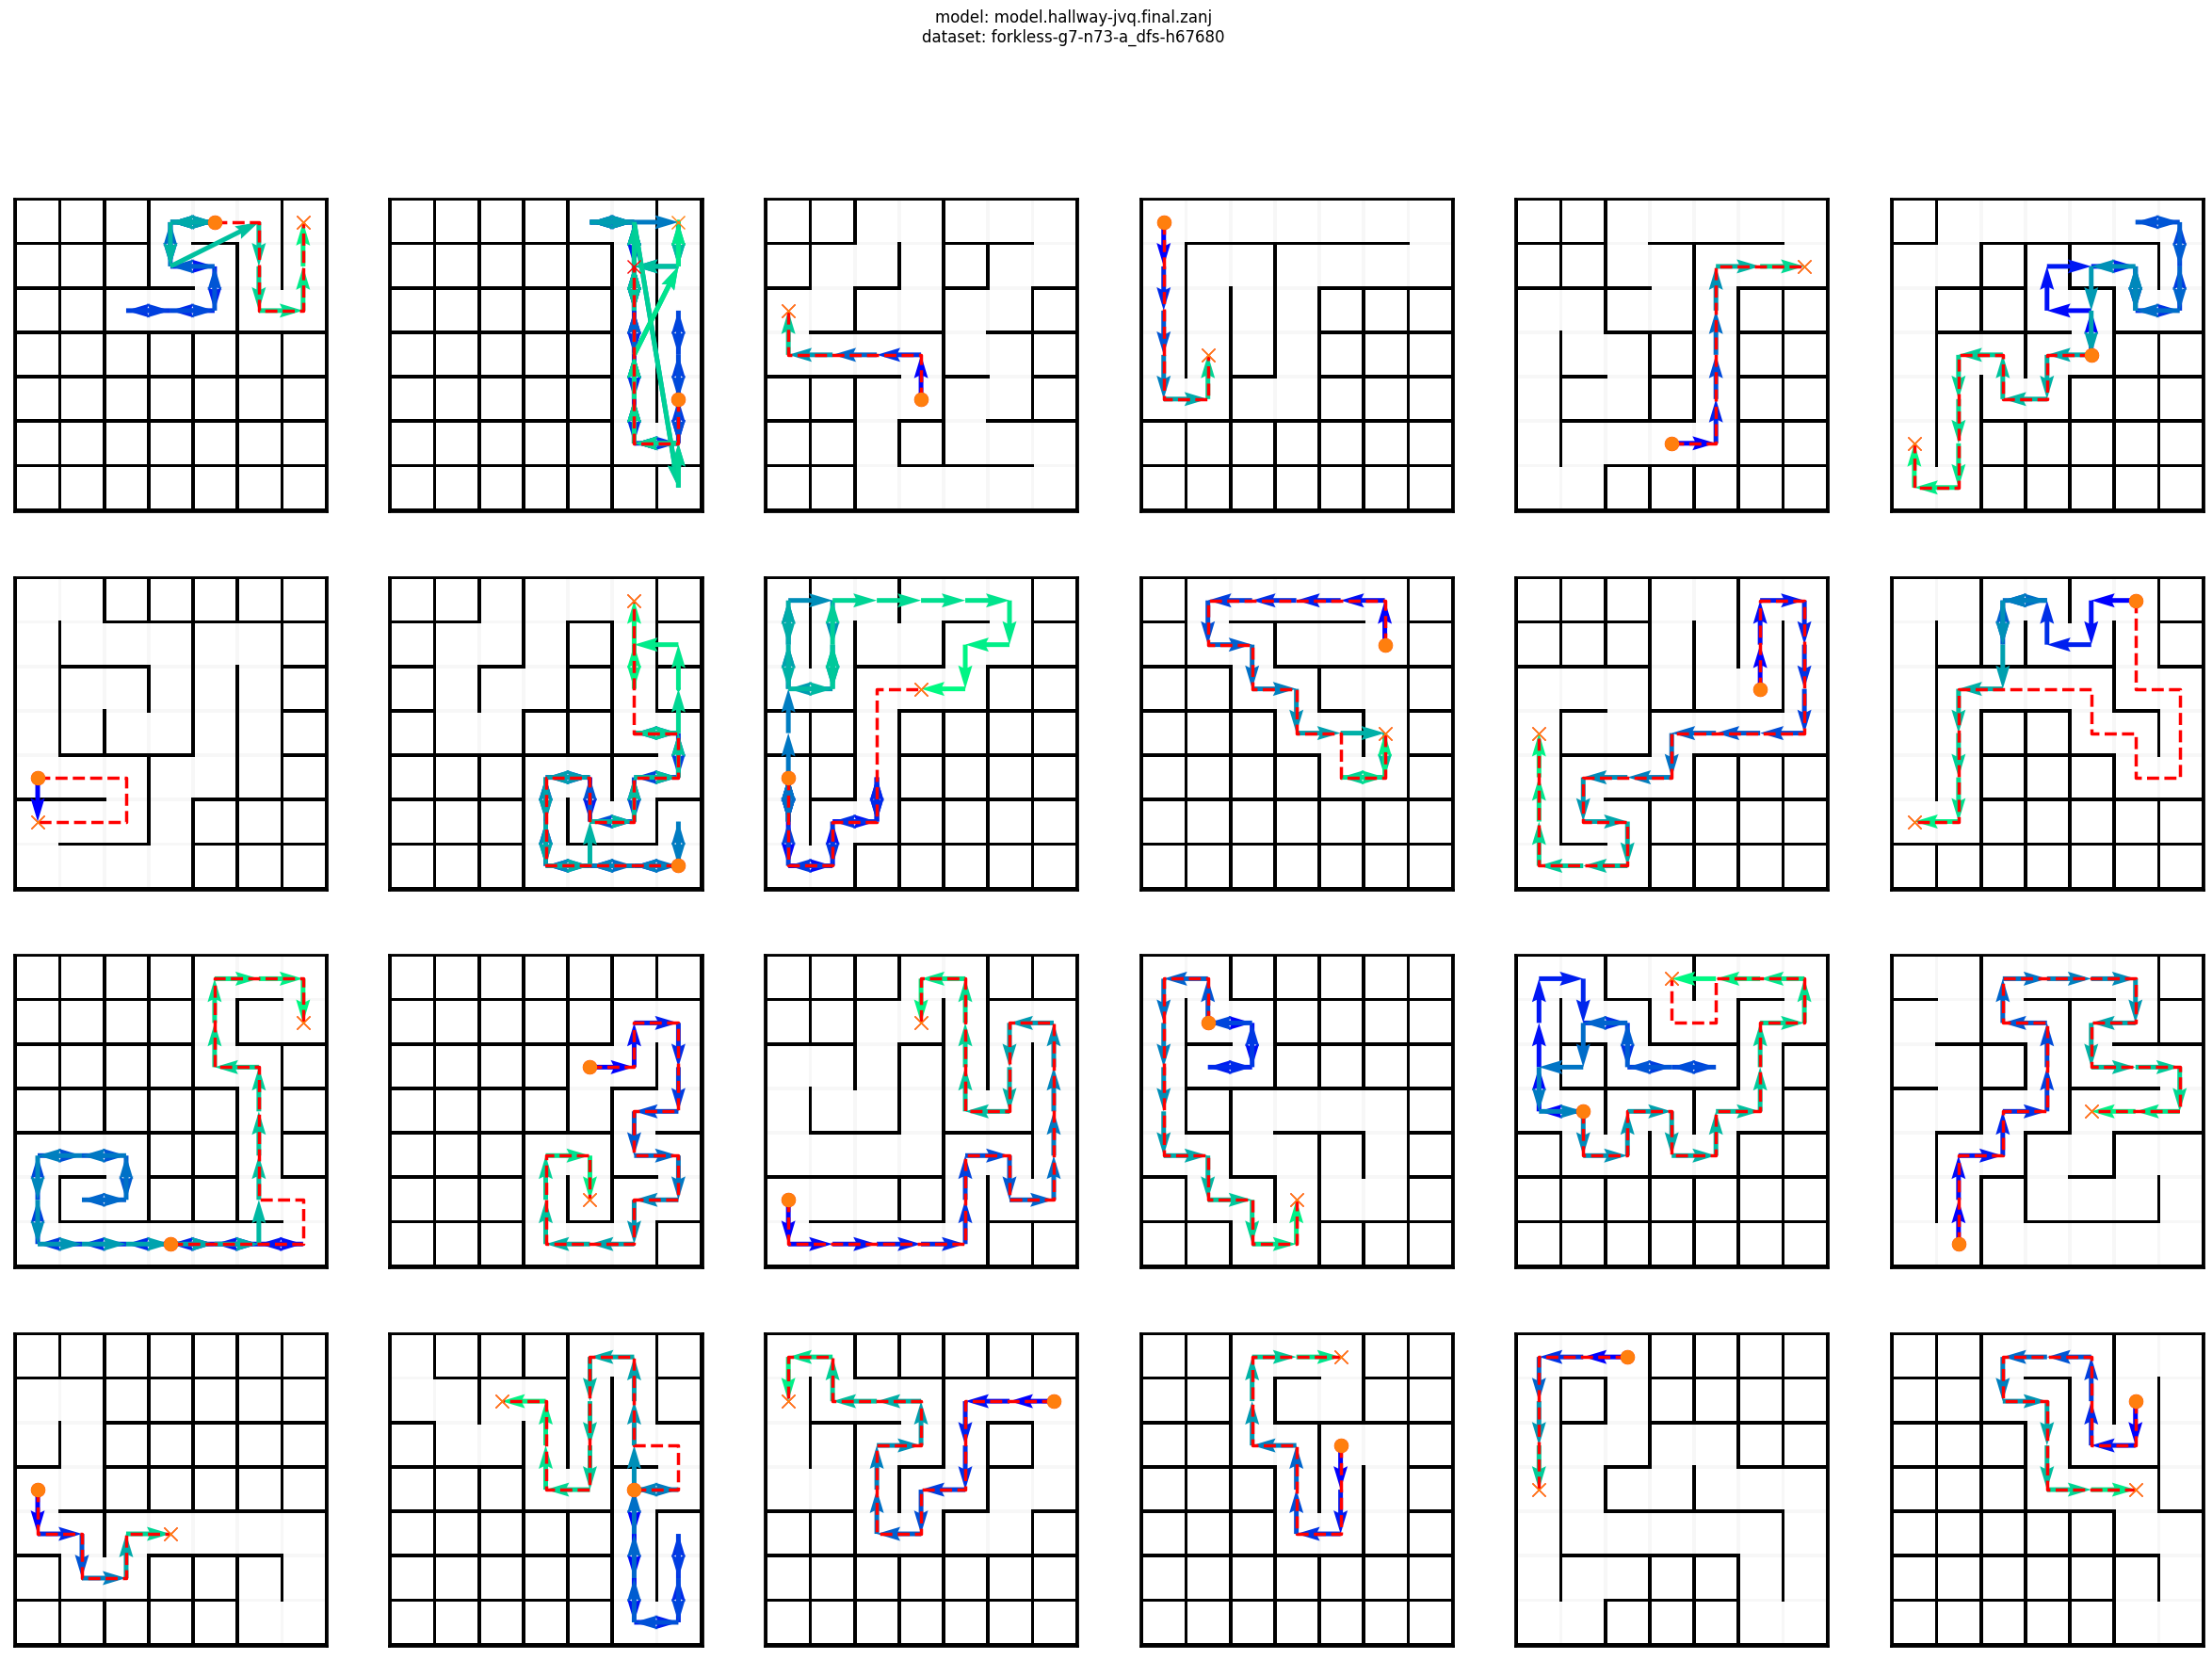

rollouts for ../models/model.hallway-jvq.final.zanj on RDFS-g7-n111-a_dfs-h82589


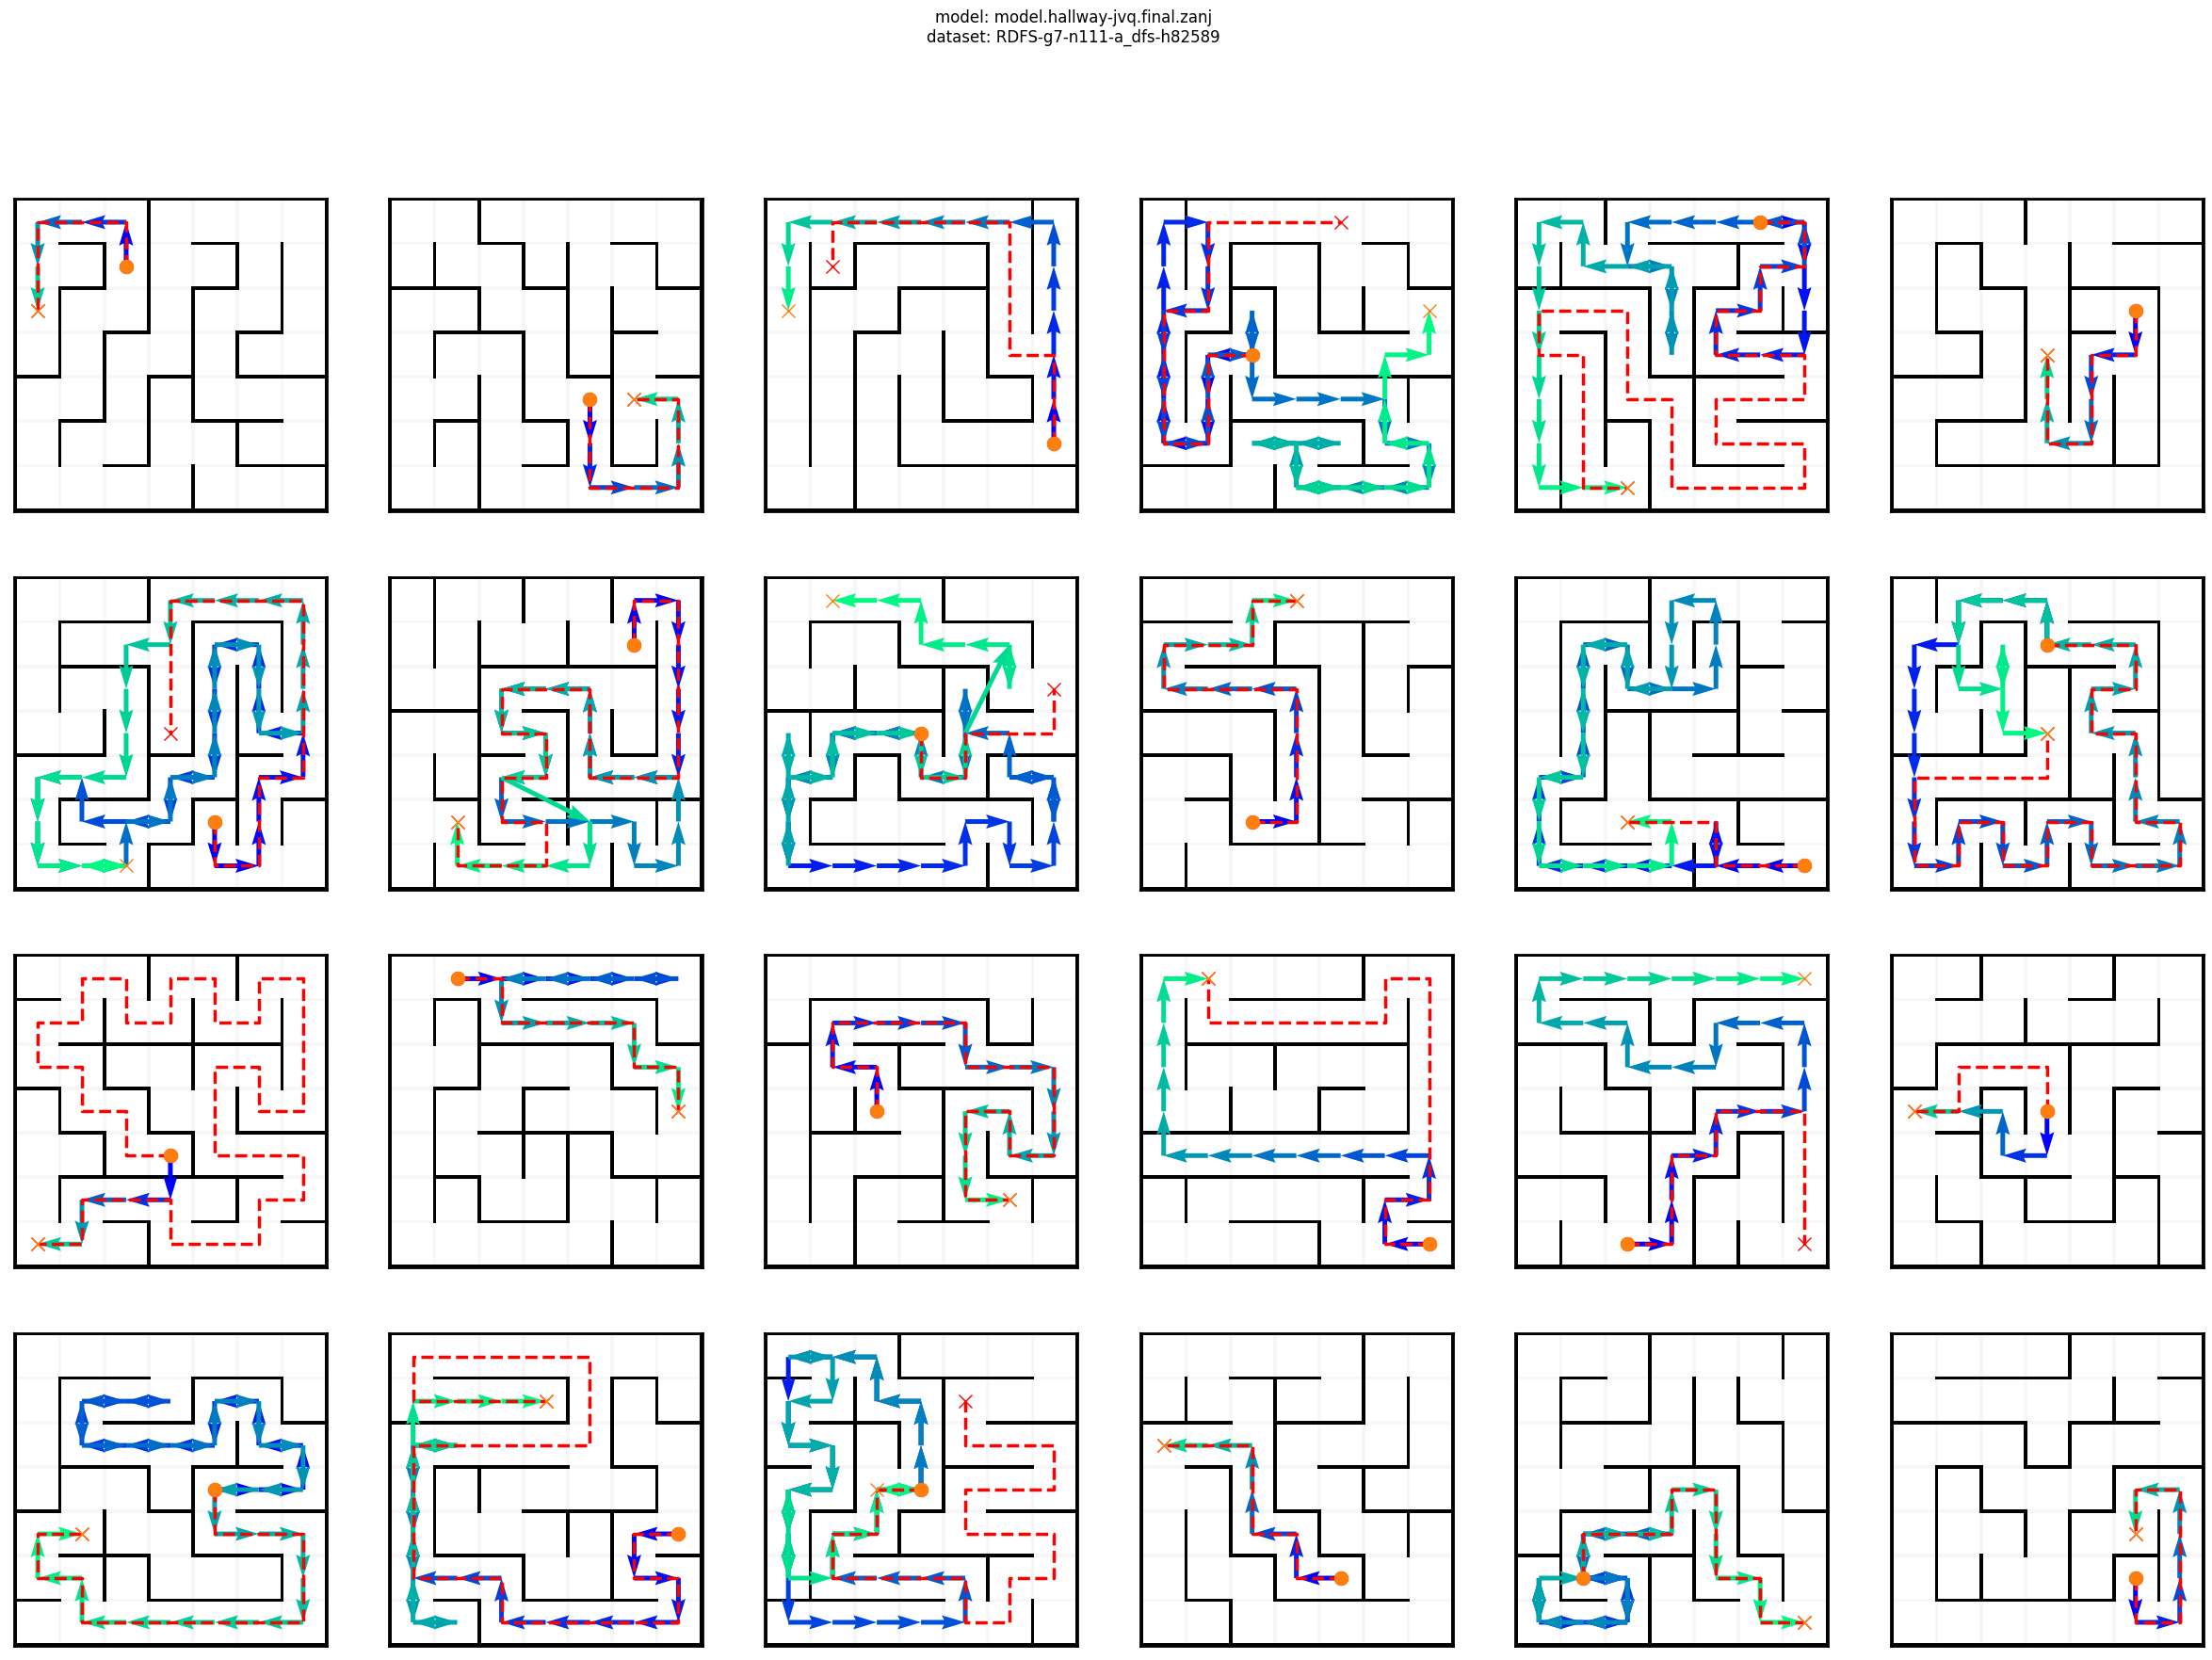

rollouts for ../models/model.hallway-jvq.final.zanj on pRDFS-g7-n98-a_dfs_percolation-h17567


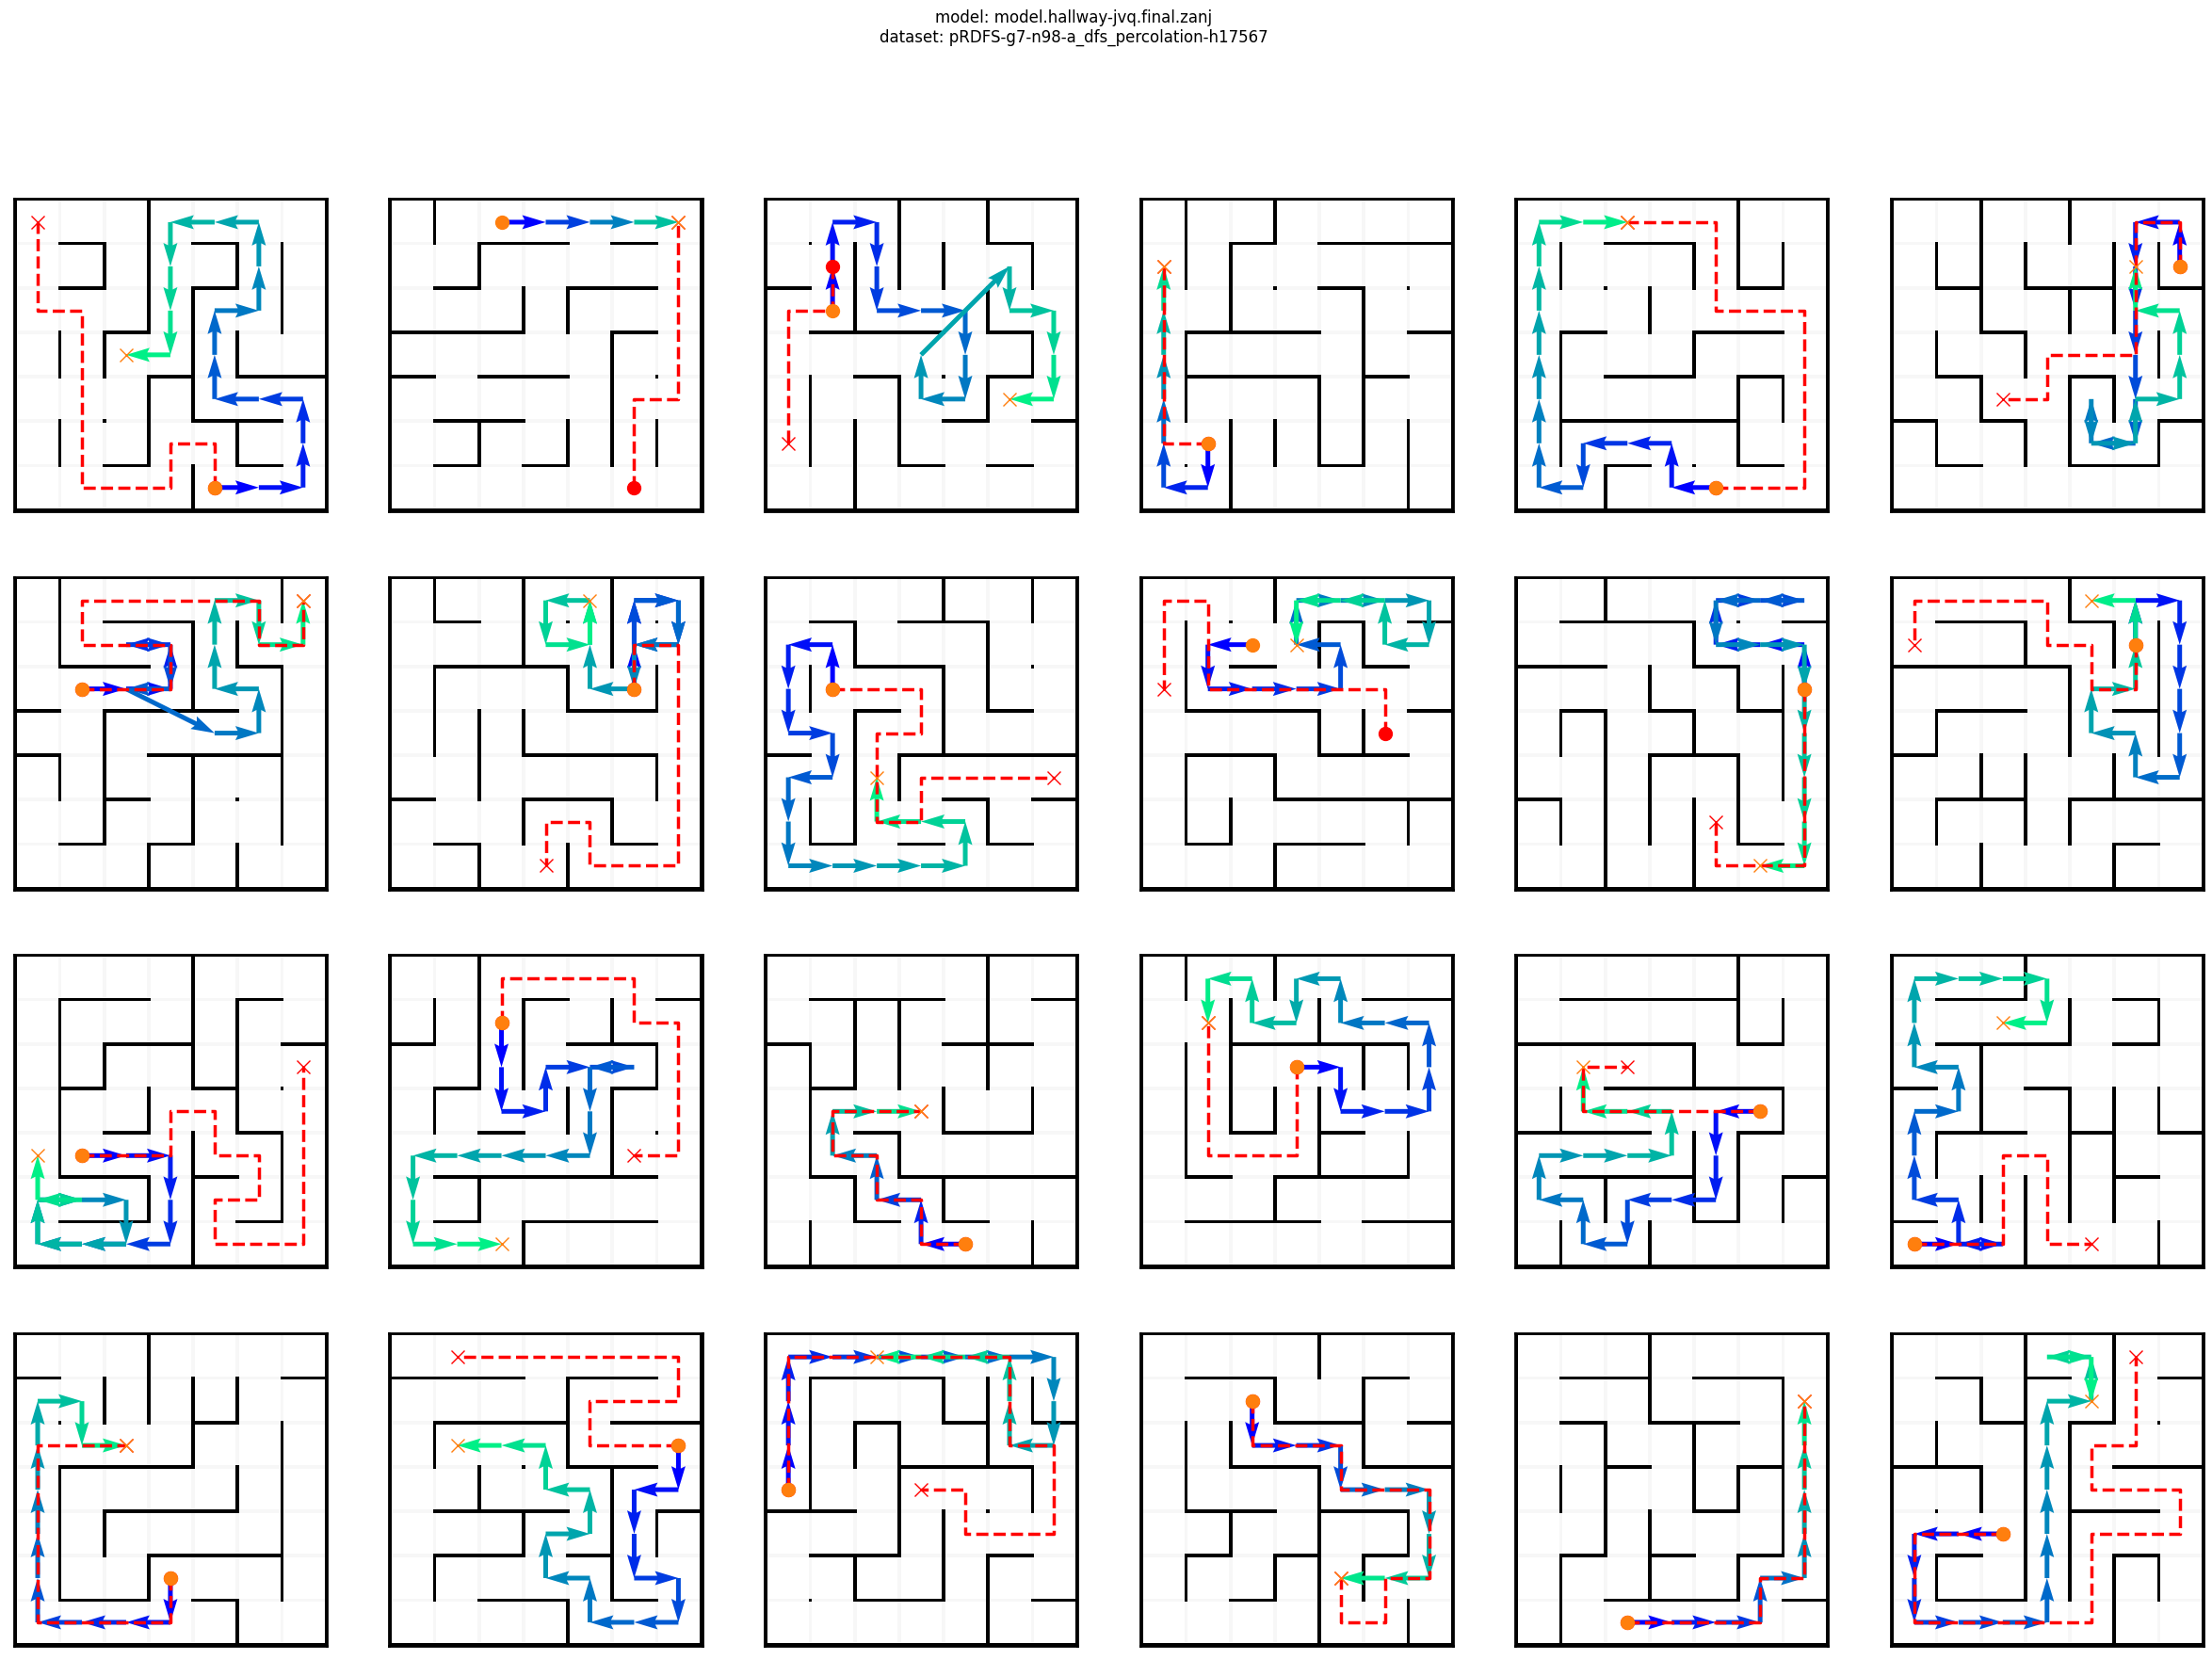

--------------------------------------------------
loaded model with 9.6M params (num_params = 9639484) from:
	path: ../models/wandb.jerpkipj.zanj
	original model name: 'model.zanj_model_config.name = 'default'', changing to 'jerpkipj'
	model tensors on devices: {device(type='cuda', index=0)}
rollouts for ../models/wandb.jerpkipj.zanj on forkless-g6-n82-a_dfs-h83607


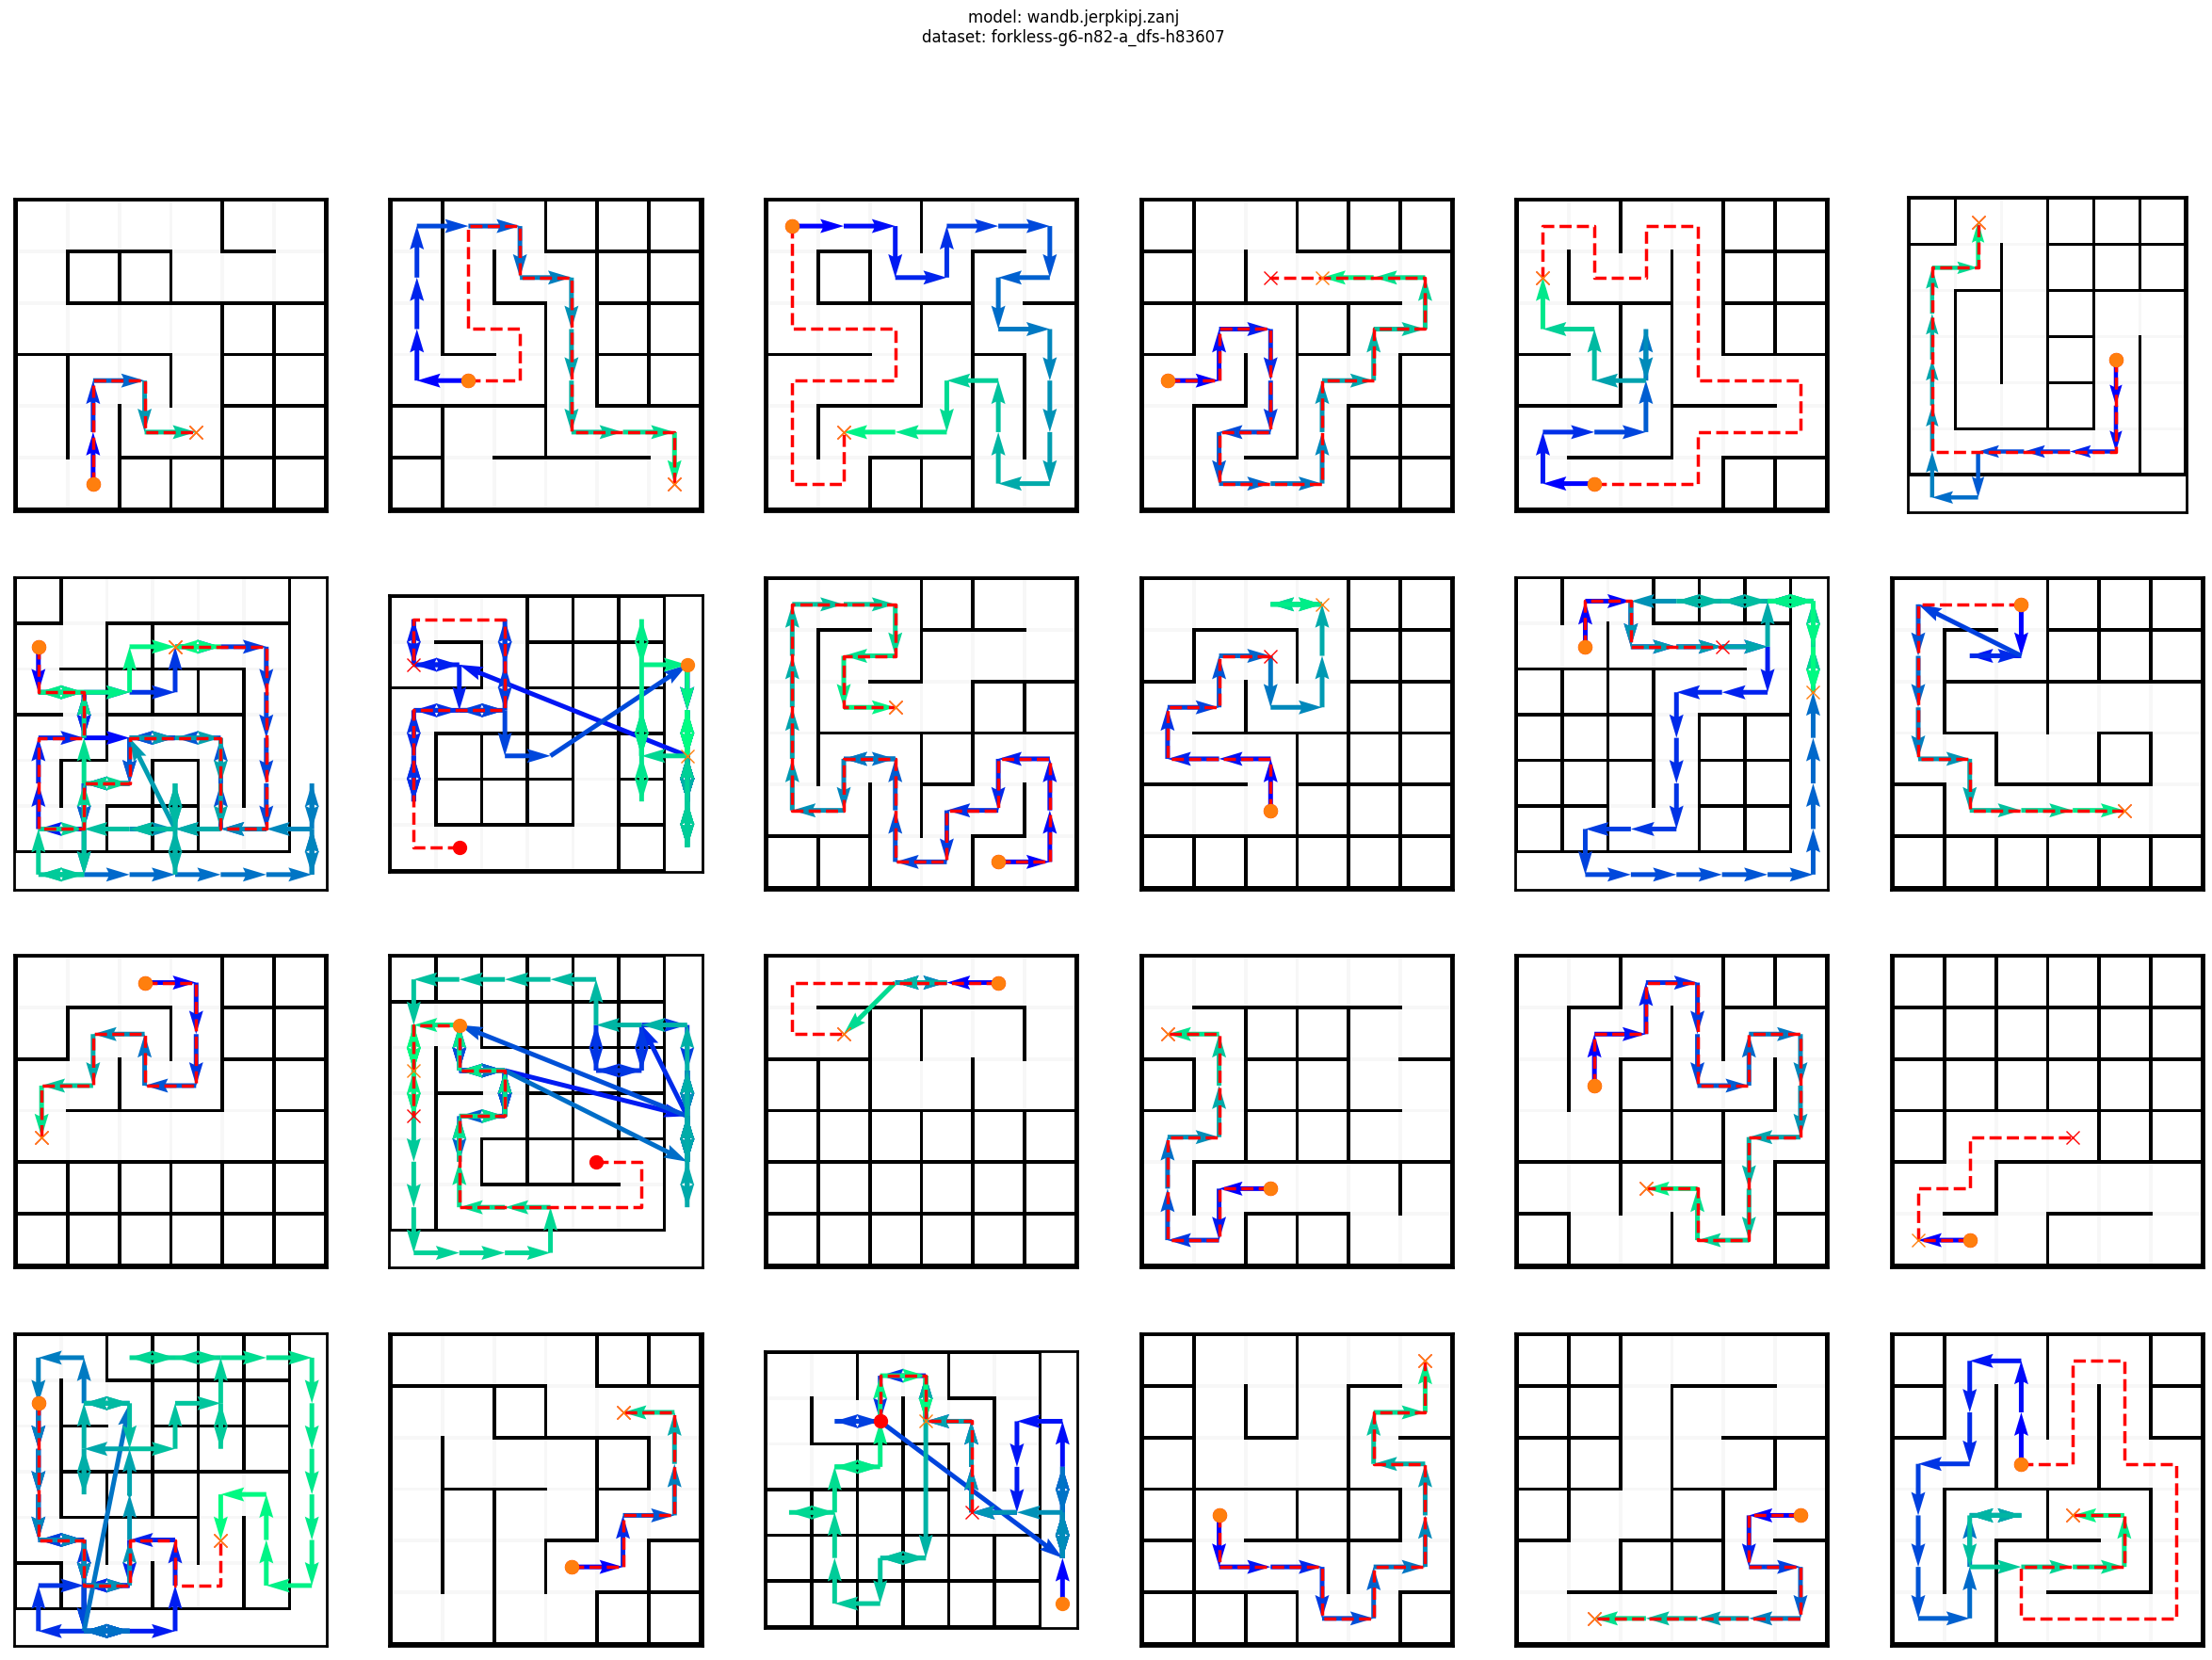

rollouts for ../models/wandb.jerpkipj.zanj on RDFS-g6-n102-a_dfs-h18303


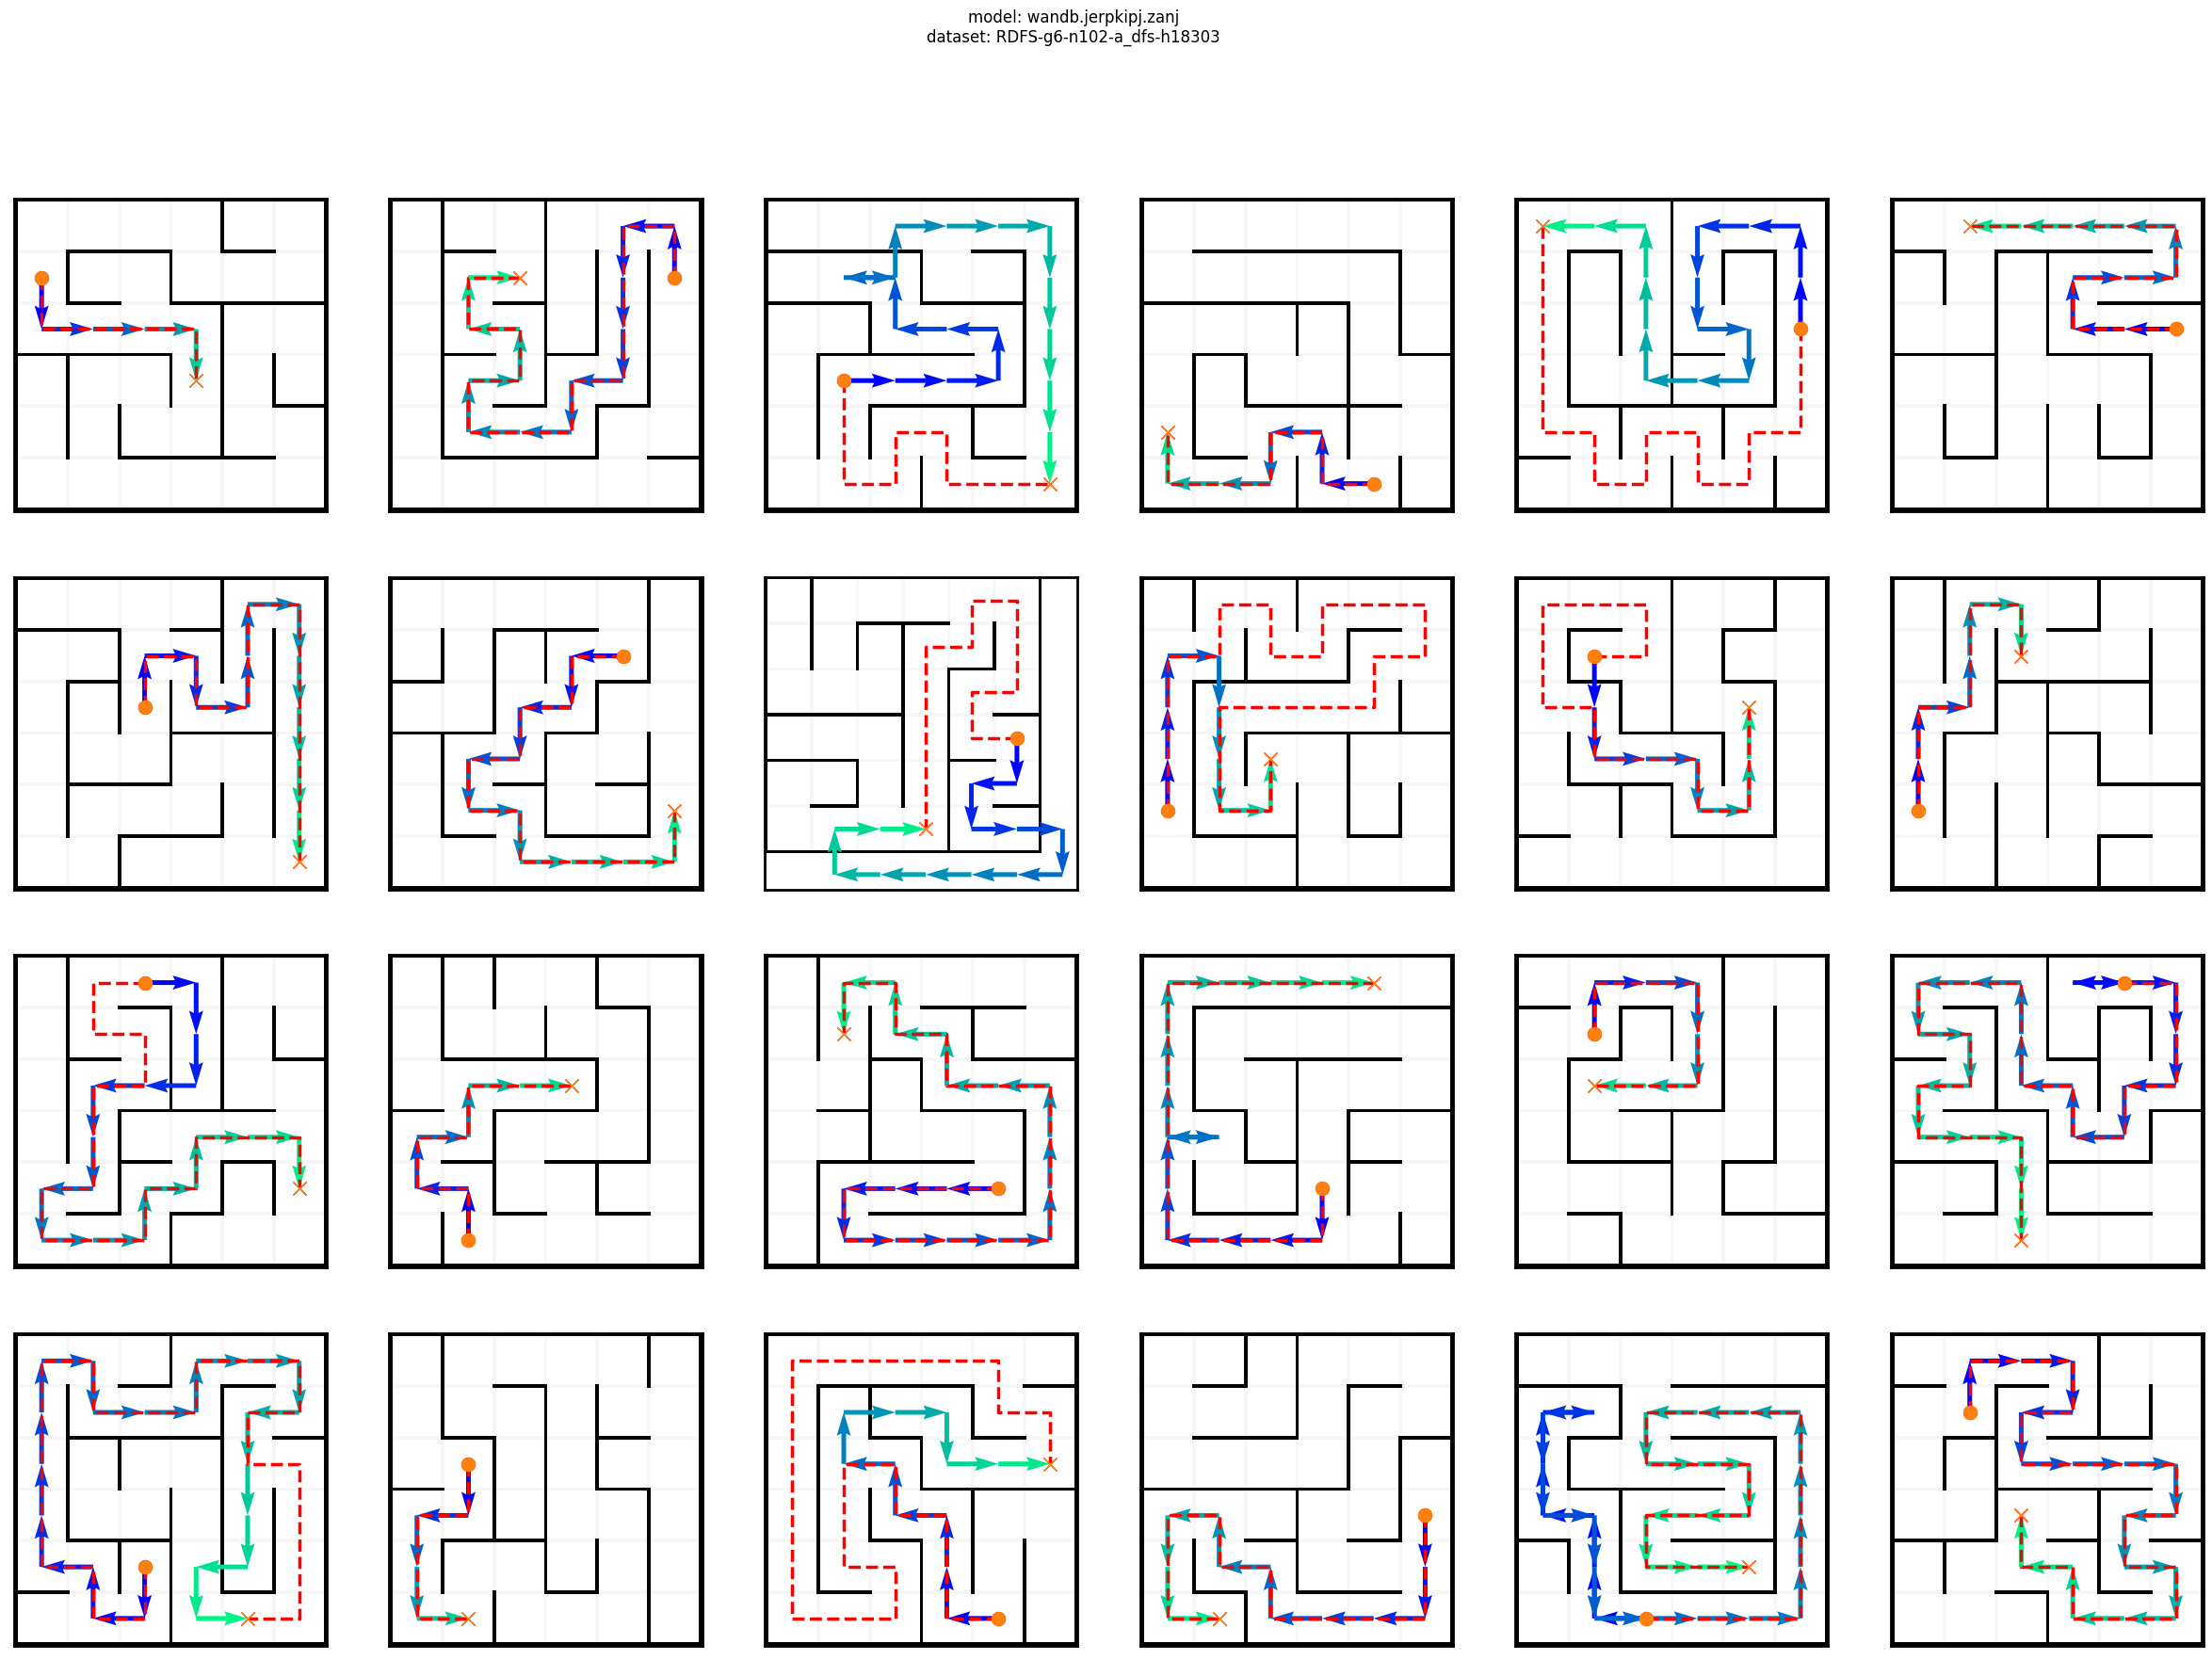

rollouts for ../models/wandb.jerpkipj.zanj on pRDFS-g6-n84-a_dfs_percolation-h29153


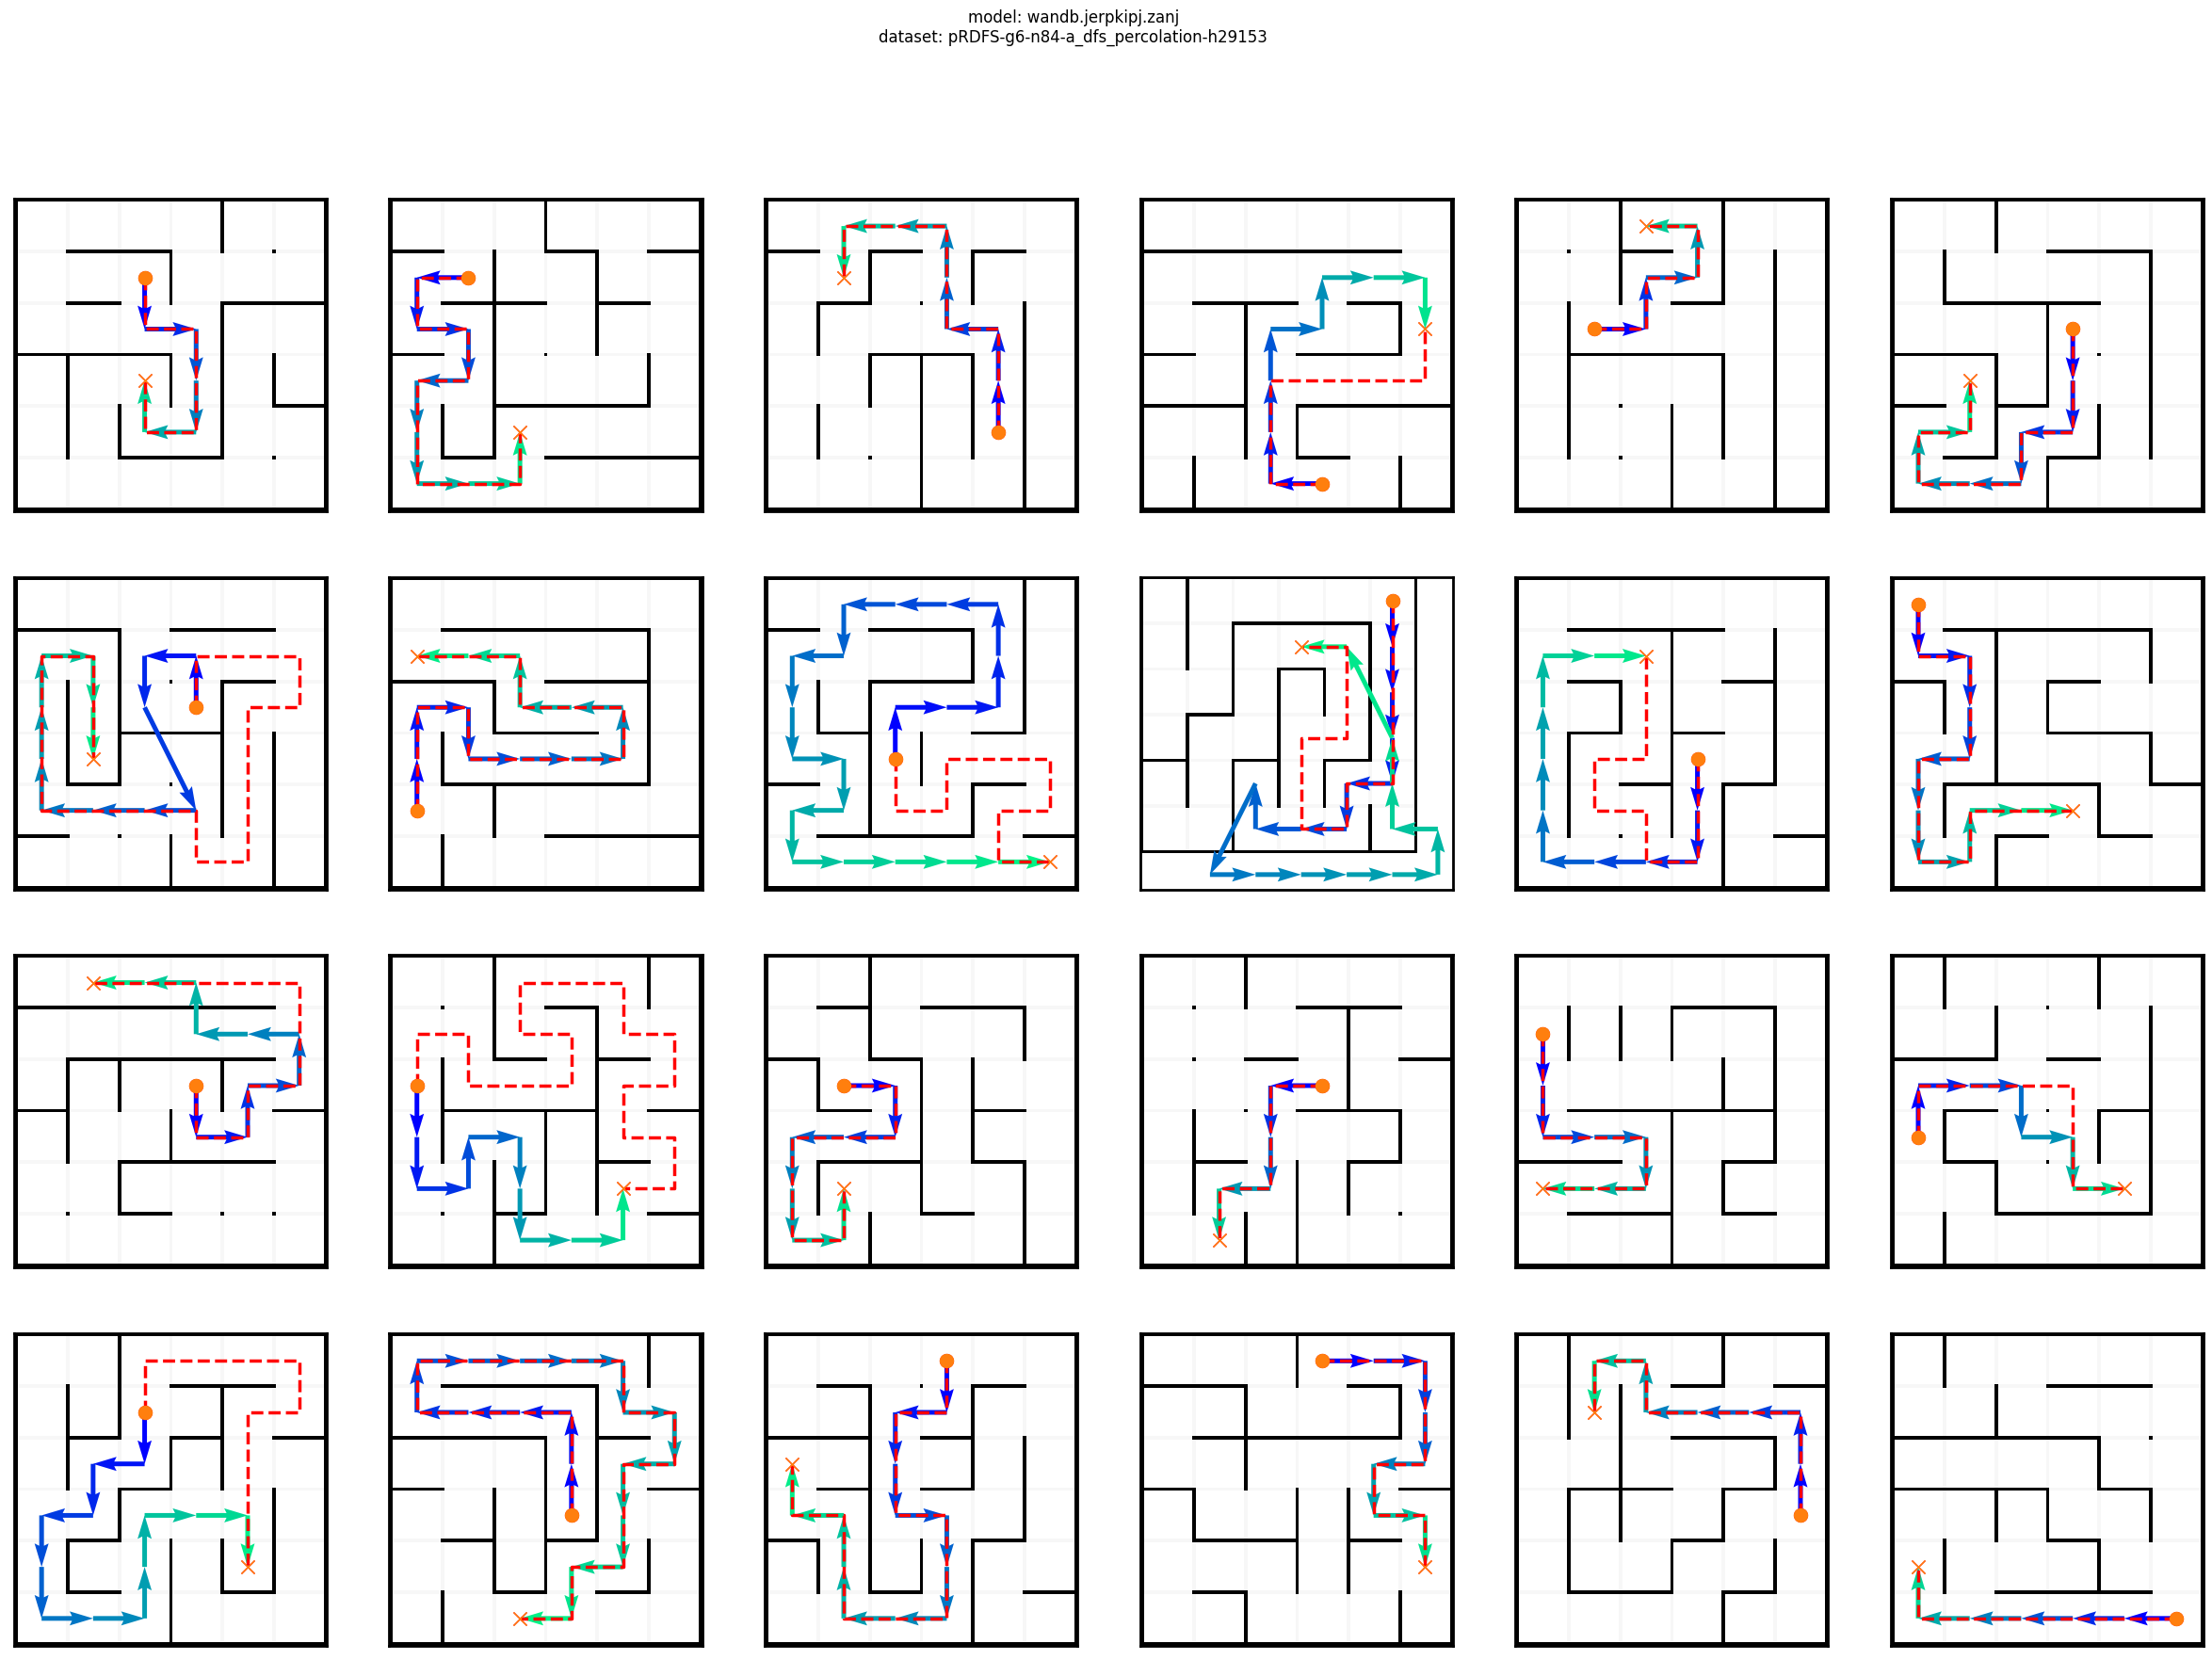

rollouts for ../models/wandb.jerpkipj.zanj on forkless-g7-n73-a_dfs-h67680


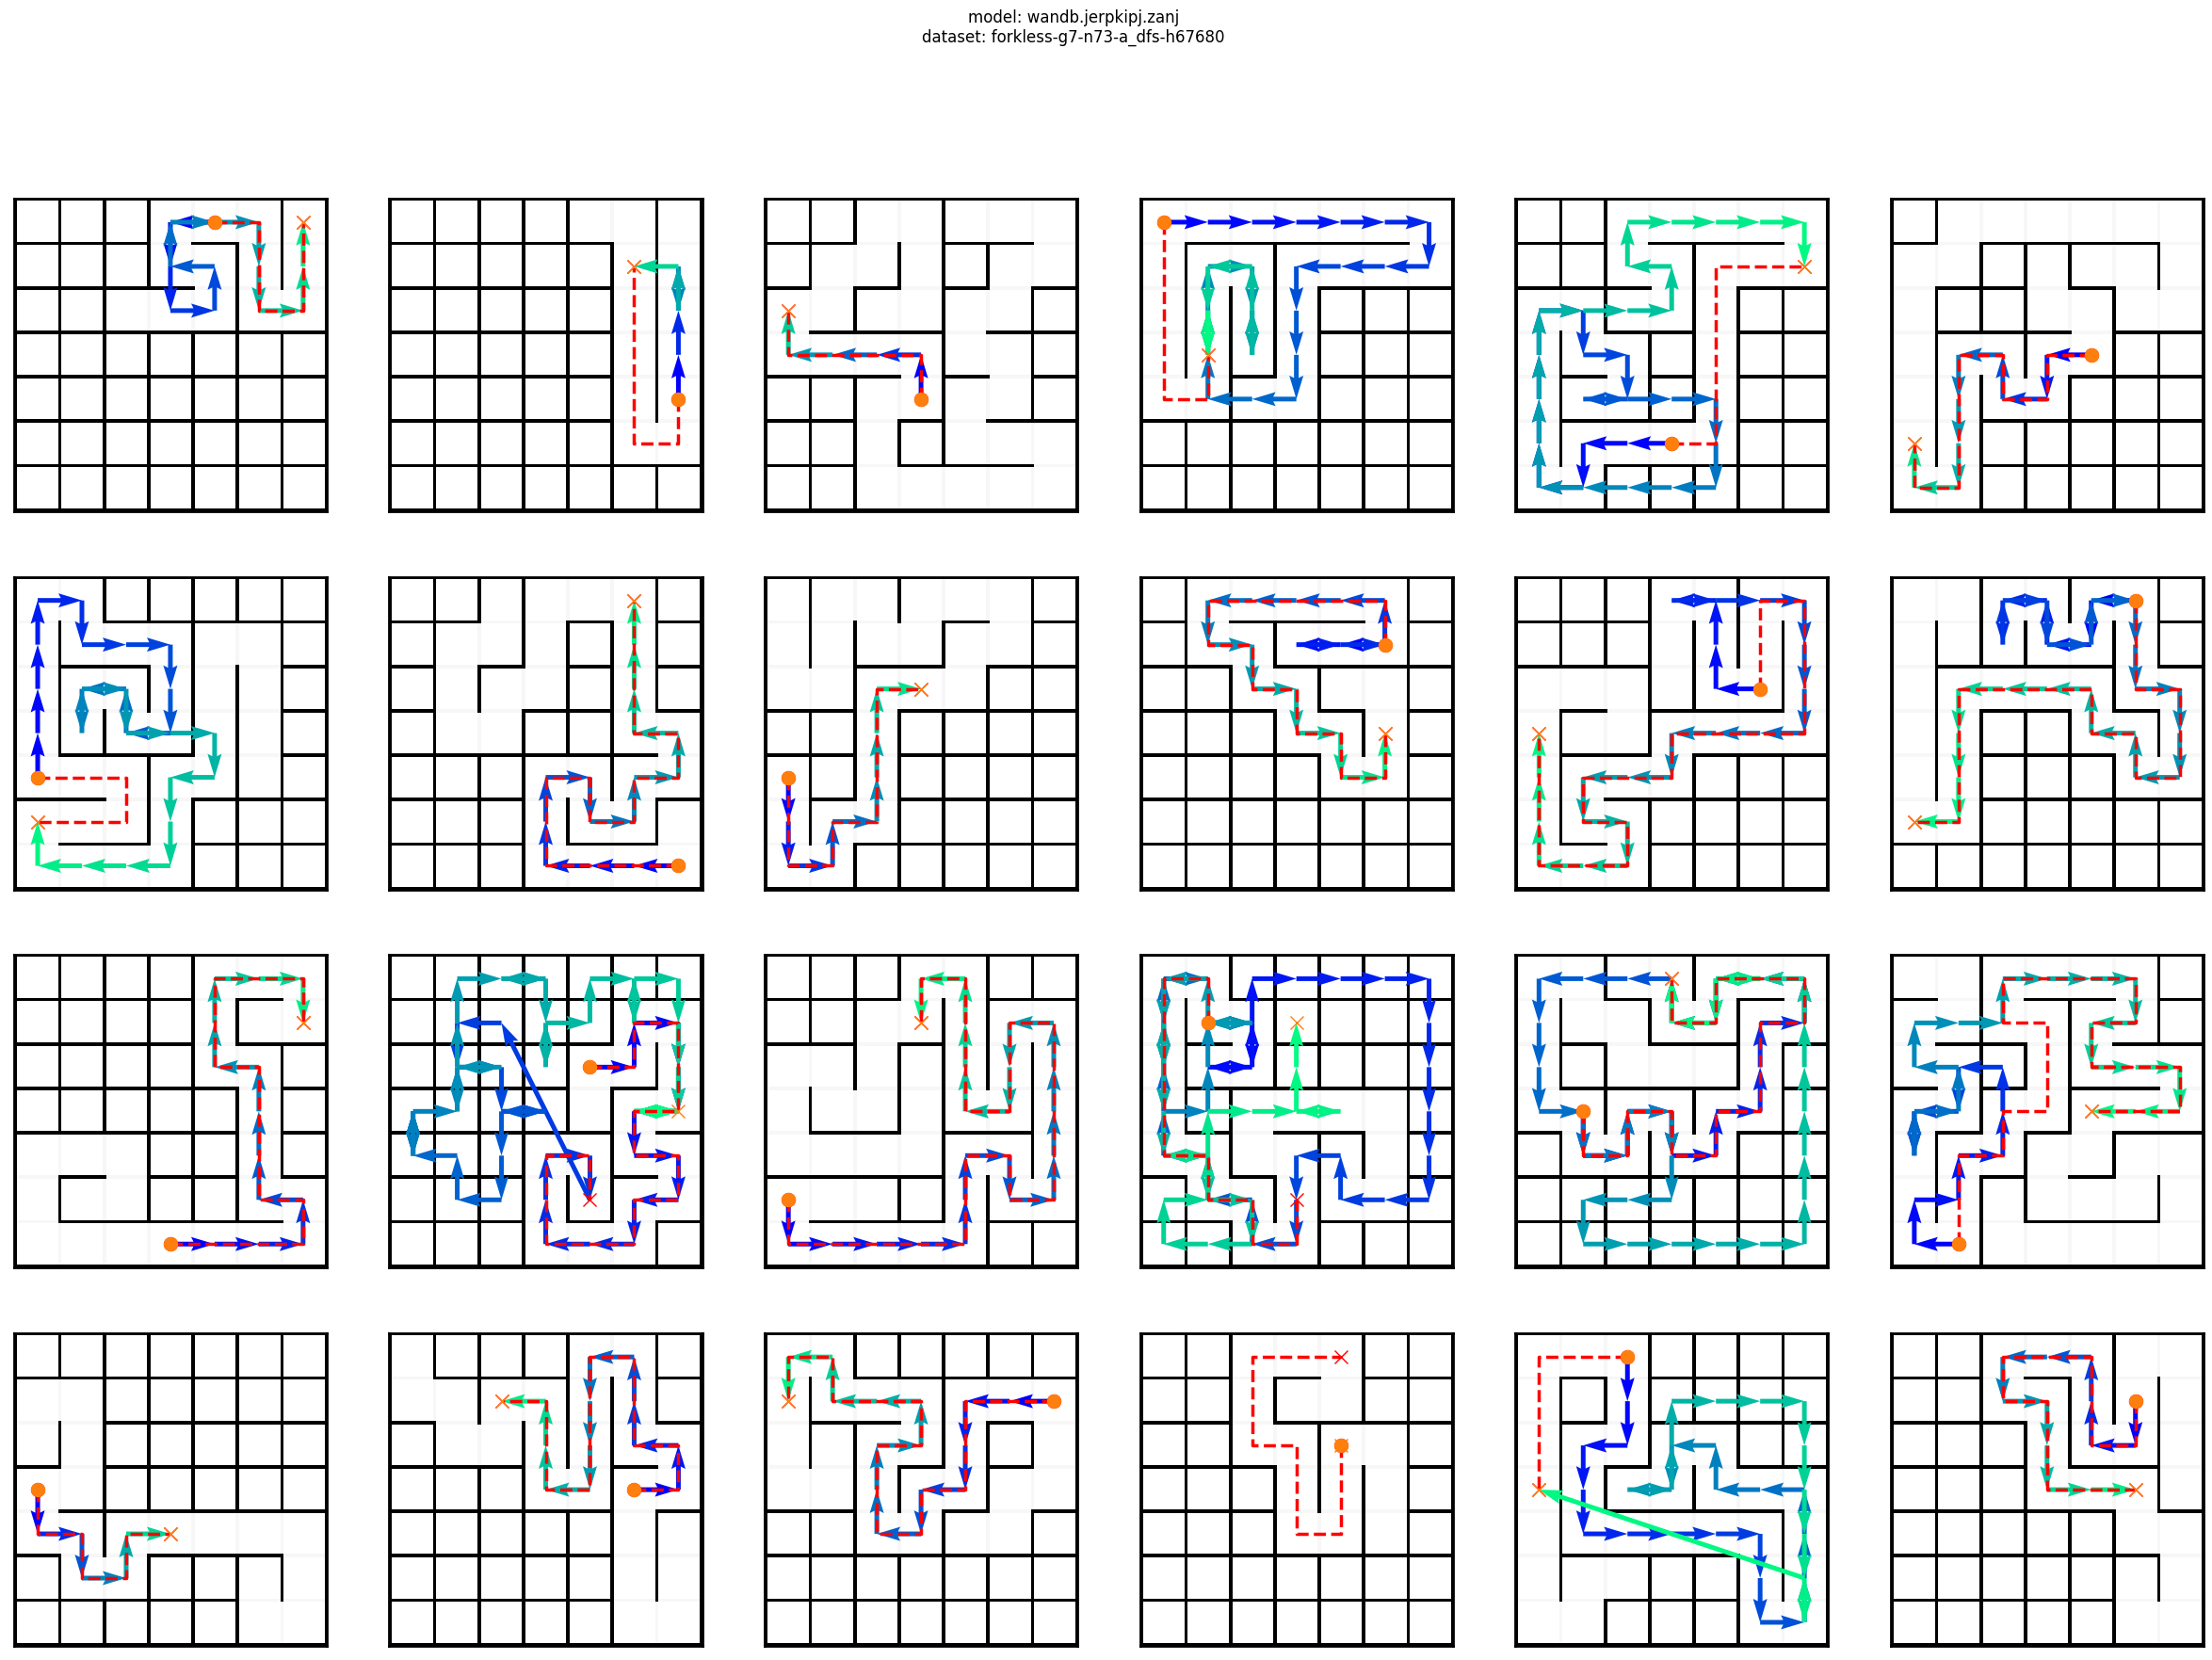

rollouts for ../models/wandb.jerpkipj.zanj on RDFS-g7-n111-a_dfs-h82589


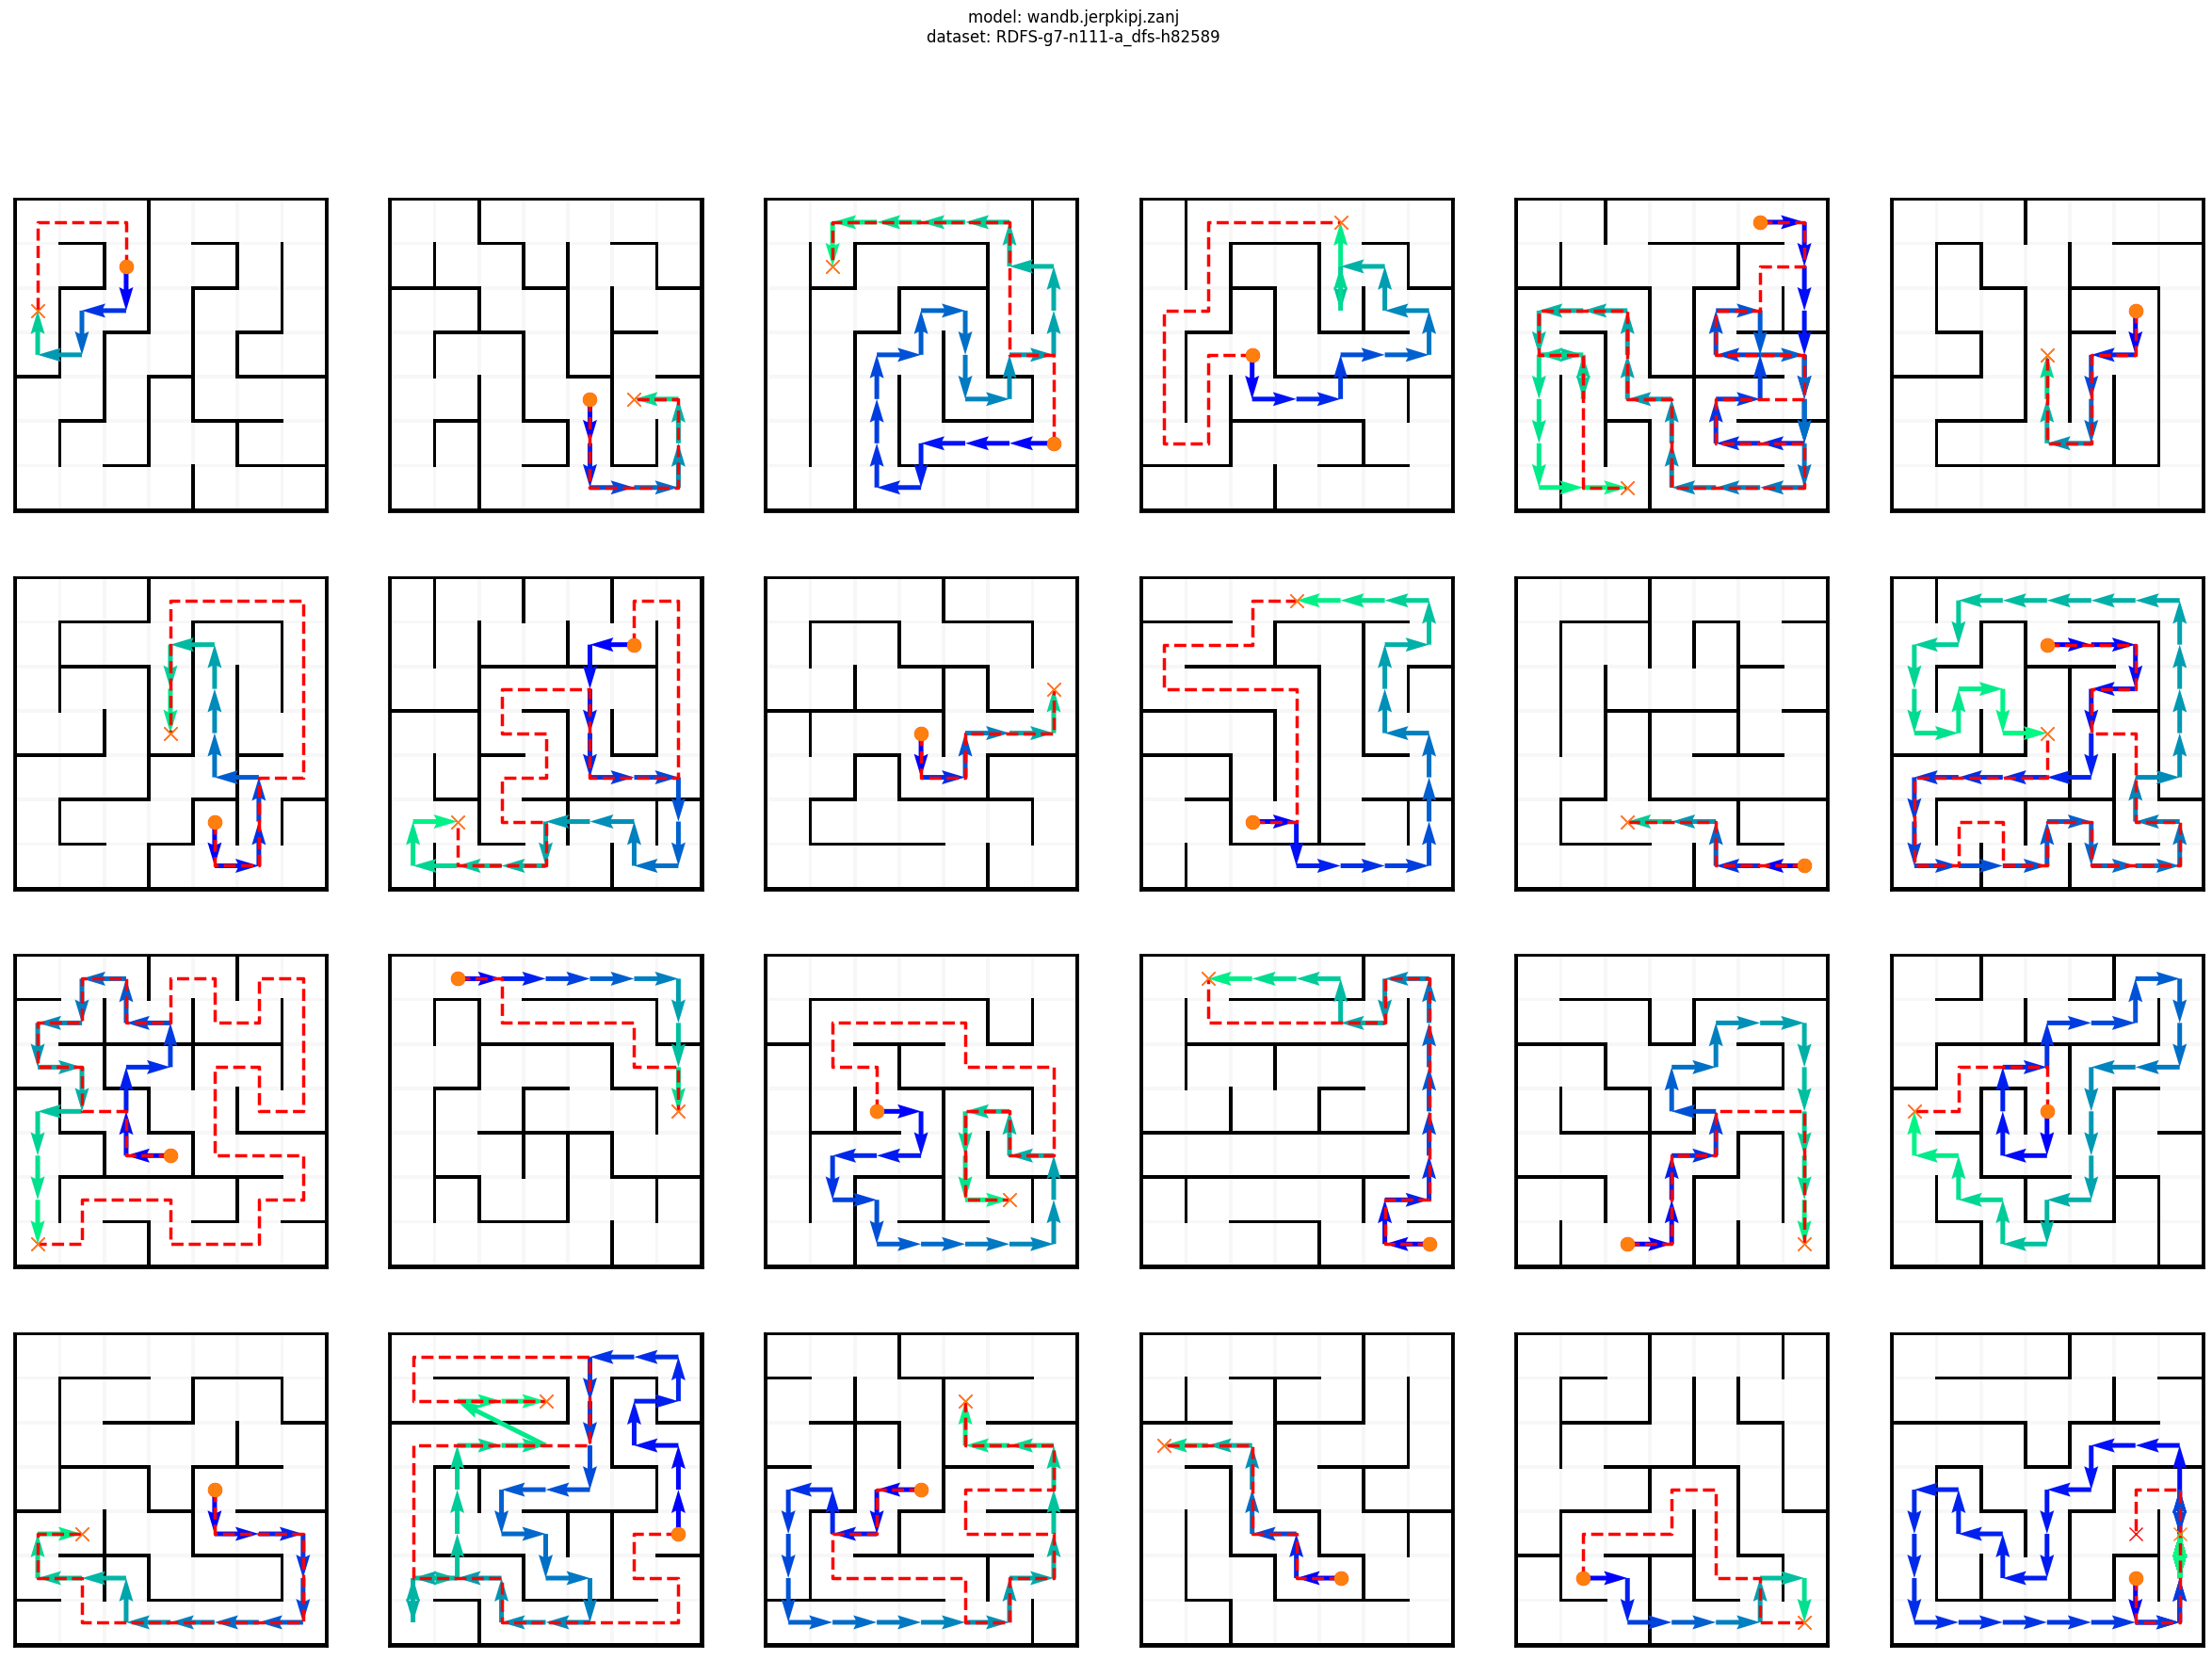

rollouts for ../models/wandb.jerpkipj.zanj on pRDFS-g7-n98-a_dfs_percolation-h17567


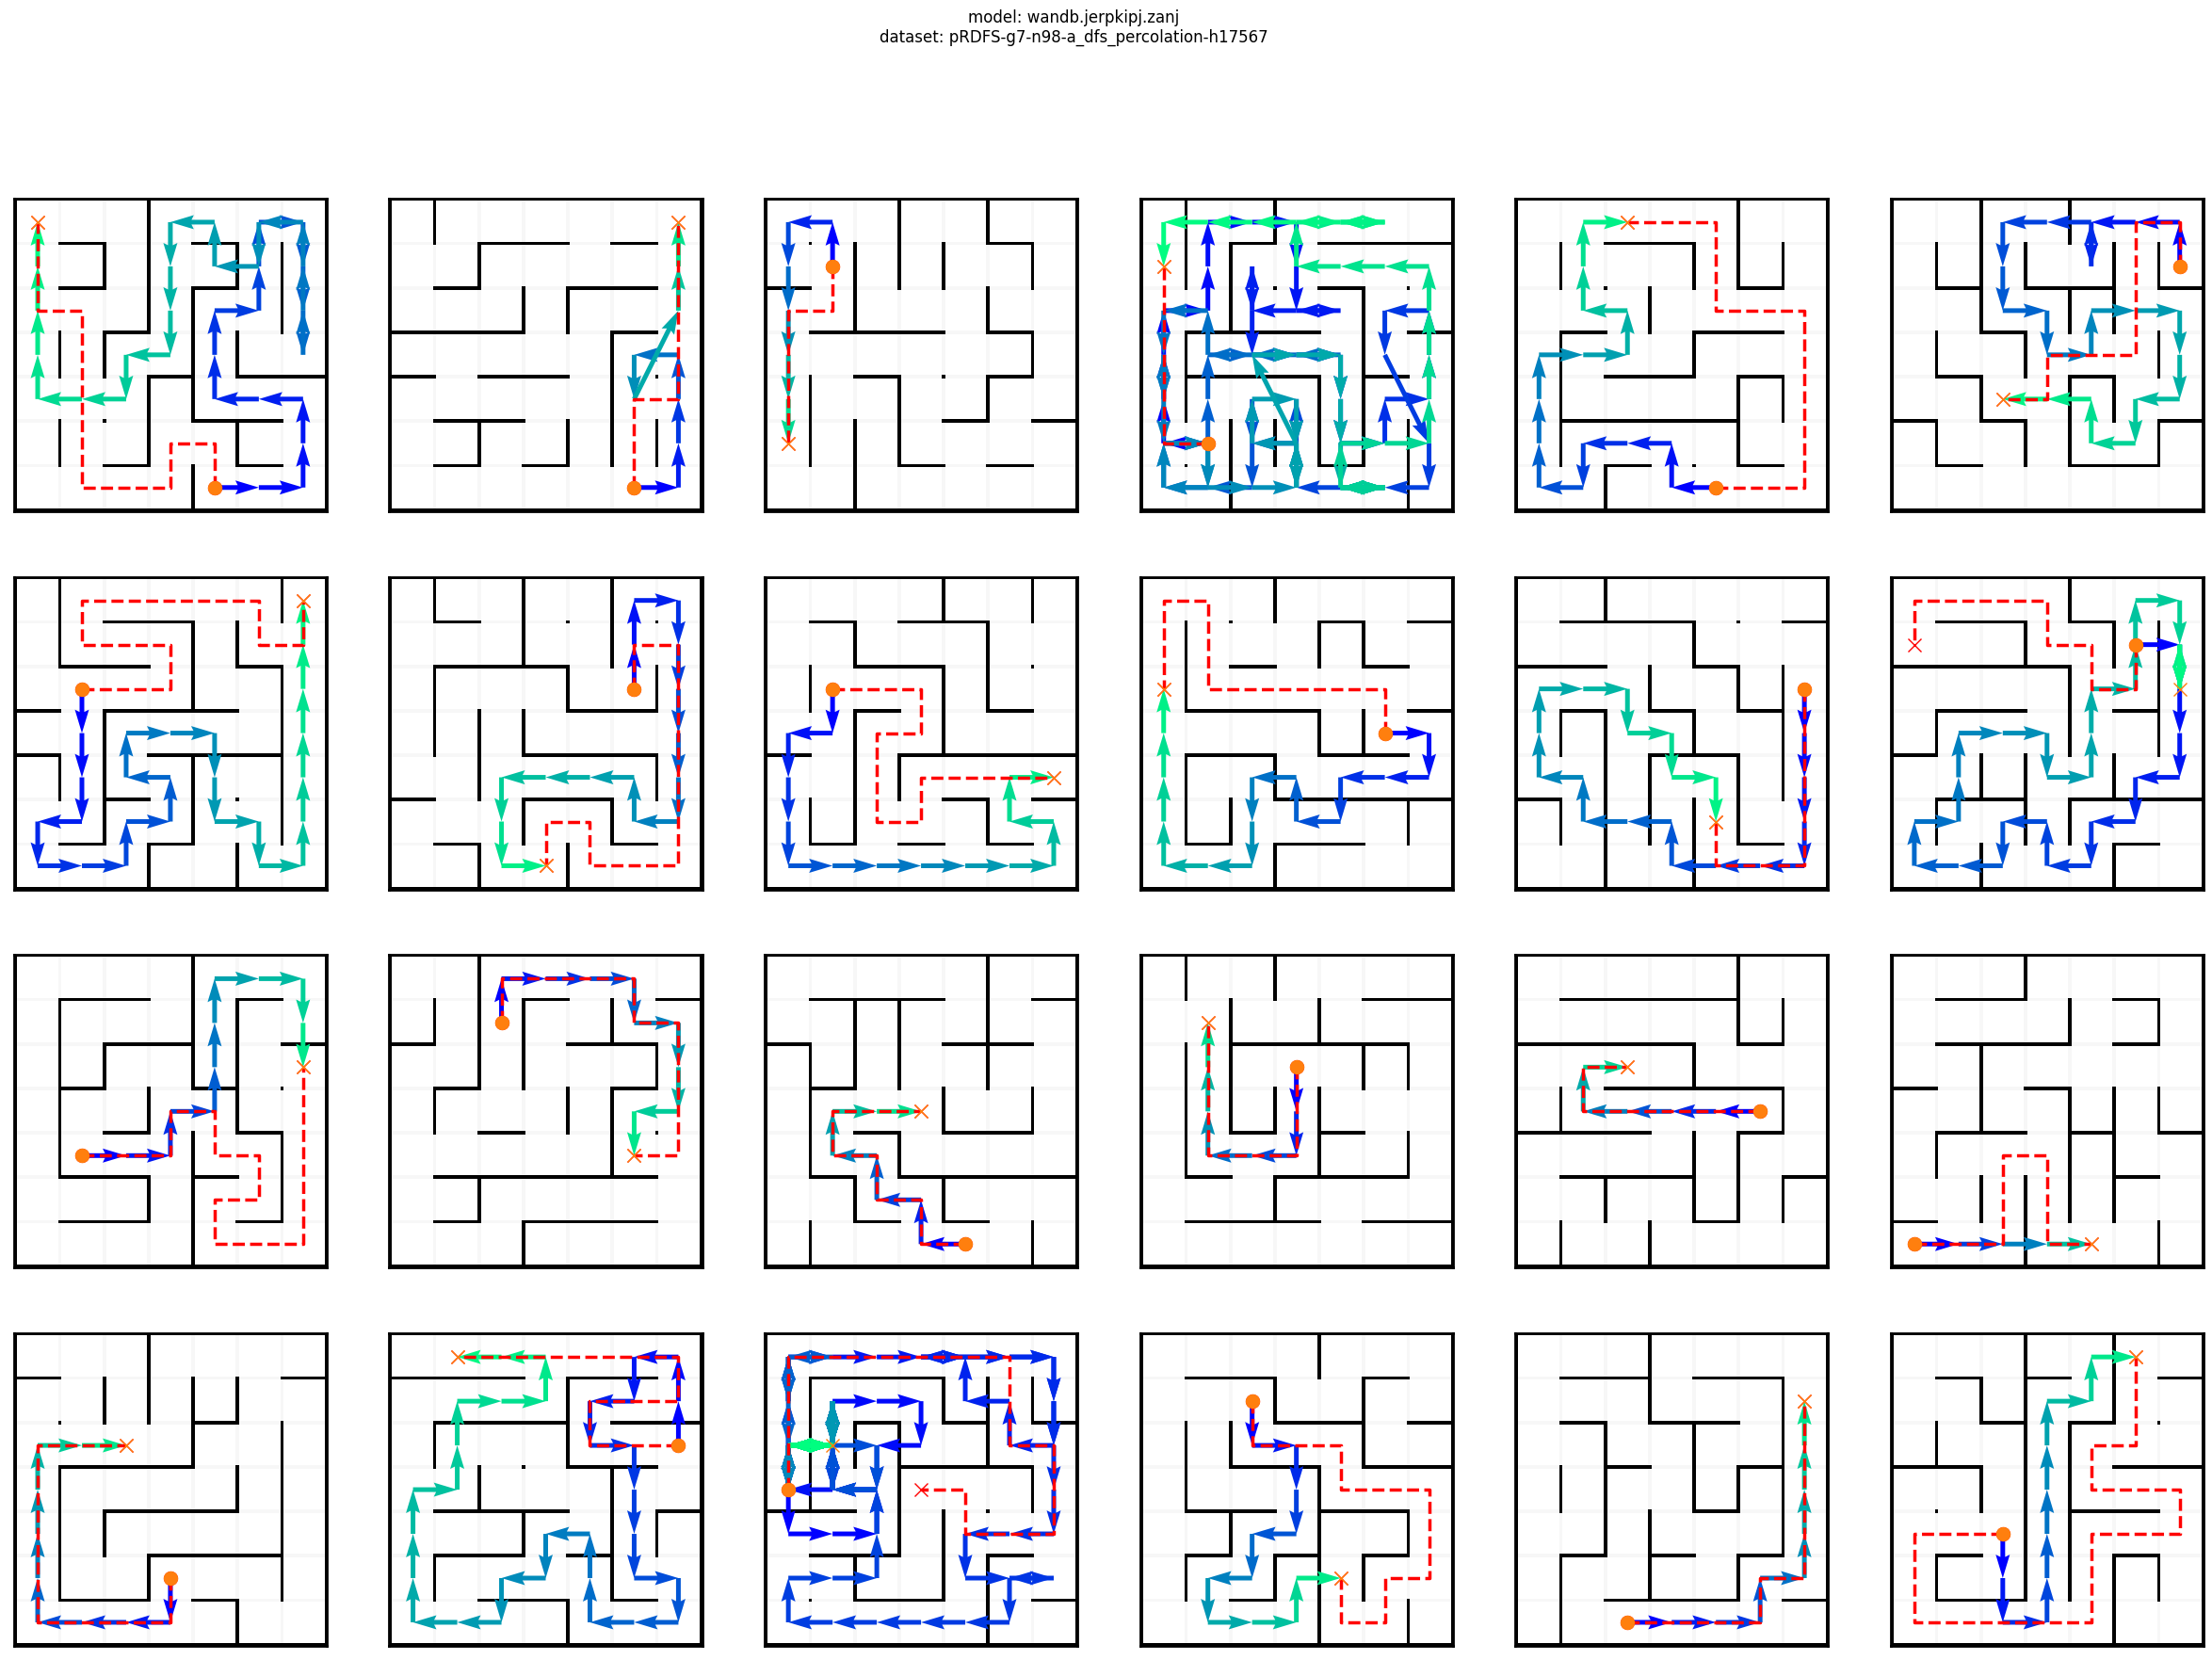

In [7]:
def generate_eval_table(
	models_paths: list[str],
	datasets: list[MazeDataset],
) -> pd.DataFrame:
	
	from maze_dataset.plotting import MazePlot, PathFormat
	from maze_transformer.evaluation.plotting import plot_predicted_paths

	for model_path in models_paths:
		print("-"*50)
		model, _ = load_model_with_test_data(
			model_path=model_path,
			dataset_cfg_source=None,
			n_examples=None,
		)

		# iter over datasets
		for dataset in datasets:
			print(f"rollouts for {model_path} on {dataset.cfg.to_fname()}")

			plot_predicted_paths(
				model, 
				dataset, 
				n_mazes=24,
				max_new_tokens=50, 
				row_length=6, 
				figsize_scale=5,
				predicted_path_fmt=PathFormat(cmap="winter"),
				show=False,
				print_generations=False,
			)
			plt.suptitle(f"model: {model_path.split('/')[-1]}\ndataset: {dataset.cfg.to_fname()}")
			plt.savefig(f"rollouts/{model_path.split('/')[-1]}.{dataset.cfg.to_fname()}.pdf")
			plt.show()

generate_eval_table(
	models_paths=MODELS_PATHS,
	datasets=DATASETS,
)

# run evals

In [ ]:
def generate_eval_table(
	models_paths: list[str],
	datasets: list[MazeDataset],
	rollouts_acc: int|None = None,
	rollout_temperature: float = 0.0,
	print_completions: bool = False,
	batch_size: int|None = 16,
) -> pd.DataFrame:
	
	output: list[dict] = list()
	
	# iter over models
	for model_path in models_paths:
		print("-"*50)
		model, _ = load_model_with_test_data(
			model_path=model_path,
			dataset_cfg_source=None,
			n_examples=None,
		)

		# iter over datasets
		for dataset in datasets:
			print(f"evaluating {model_path} on {dataset.cfg.to_fname()}")

			tokenizer: MazeTokenizer = model.zanj_model_config.maze_tokenizer
			task_prompt_targets: dict[str, TaskPrompt] = get_task_prompts_targets(
				dataset=dataset,
				maze_tokenizer=tokenizer,
				tasks=LOGIT_ATTRIB_TASKS,
			)

			print(f"\trunning task evals")
			task_results: dict[str, TaskEvalResult] = eval_model_across_tasks(
				model = model,
				task_prompts = task_prompt_targets,
				do_cache=False,
			)

			# TODO: store whole array of predictions, not just mean -- use this for correlations between task accuracies?
			output_item: dict = dict(
				model=model.config.name,
				dataset=dataset.cfg.to_fname(),
				**{
					task_name: task_result.predicted_correct.cpu().float().mean().item()
					for task_name, task_result in task_results.items()
				},
			)

			if rollouts_acc is not None:
				print(f"\trunning rollout evals")
				dataset_tokens: list[list[str]] = dataset.as_tokens(maze_tokenizer=tokenizer)[:rollouts_acc]
				# do rollouts
				predictions: list[list[str|tuple[int, int]]] = predict_maze_paths(
					tokens_batch=dataset_tokens,
					data_cfg=dataset.cfg,
					model=model,
					max_new_tokens=None,
					temperature=rollout_temperature,
					when_noncoord="include",
					smart_max_new_tokens=True,
					batch_size=batch_size,
				)
				
				if print_completions:
					for p, x in zip(dataset_tokens, predictions):
						p_idx: int = p.index(SPECIAL_TOKENS.PATH_START)
						p_ctx: list[str] = p[:p_idx]
						p_path: list[str] = p[p_idx:]
						print("\t\t", " ".join(p_ctx))
						print("\t\t", " ".join(p_path))
						print("\t\t", " ".join([str(t) for t in x]))

				mazes: list[SolvedMaze] = dataset.mazes[:rollouts_acc]
				assert len(predictions) == len(mazes)

				# evaluate rollouts
				rollout_eval_results: dict[str, float] = rollout_evals(
					predictions=predictions,
					mazes=mazes,
				)

				output_item.update(rollout_eval_results)

			print(f"\t{output_item}")
			output.append(output_item)

		# delete model to save memory
		del model

	return pd.DataFrame(output)

In [ ]:
RESULTS: pd.DataFrame = generate_eval_table(
	models_paths=MODELS_PATHS,
	datasets=DATASETS,
	rollouts_acc=N_MAZES,
	print_completions=False,
	batch_size=128, 
)

# view and process data

In [ ]:
RESULTS

In [ ]:
RESULTS.to_json(f"eval_results-n{N_MAZES}.json", index=True, orient="records", lines=True)

In [ ]:
# alternatively, load and processed a saved dataset
import pandas as pd
RESULTS = pd.read_json(f"eval_results-n256.json", orient="records", lines=True)

In [ ]:
RESULTS['model/dataset'] = (
	RESULTS['model'].apply(lambda x: x.split('-')[0]) 
	+ '/' 
	+ RESULTS['dataset']
)

In [ ]:
transposed_df = RESULTS.drop(['model', 'dataset'], axis=1).set_index('model/dataset').T.reset_index()
transposed_df.rename(columns={'index': 'Metric'}, inplace=True)
# convert all to percentages
transposed_df = transposed_df.applymap(lambda x: f"{x:.1%}" if isinstance(x, float) else x)
transposed_df
# columns by what comes after the slash
transposed_df = transposed_df[
	sorted(
		transposed_df.columns, 
		key = lambda x: (
			"0" if x == 'Metric' 
			else x
			# else ["hallway", "forkless", "RDFS", "pRDFS"].index(x.split('/')[1].split('-')[0])
		)
	)
]
transposed_df

In [ ]:
transposed_df.to_csv(f"eval_results-n256.csv", index=False)

In [ ]:
print(transposed_df.to_latex(index=False))

In [ ]:
df_g6 = pd.read_csv("processed/eval_results-n256-g6.csv")
df_g7 = pd.read_csv("processed/eval_results-n256-g7.csv")
print(df_g6.to_latex(index=False))
print("="*80)
print(df_g7.to_latex(index=False))